# Human Diversity Data

This notebook includes getting the human diversity data in shape for the model fitting. 

## Configuration

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [66]:
import os
import copy
from functools import partial
import numpy as np
import scipy.stats as stats
from scipy import interpolate
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tabulate import tabulate

from bgspy.genome import Genome
from bgspy.utils import mean_ratio, rel_error
from bgspy.utils import mean_ratio
from bgspy.bootstrap import percentile_ci
from bgspy.data import GenomeData, get_accessible_from_seqs
from bgspy.data import pi_from_pairwise_summaries
from bgspy.optim import optim_diagnotics_plot

In [3]:
plt.show()

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

FIGDIR = '../manuscript/figures/'

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

## Validating the Raw Ref/Alt allele Count Data

My tool `tools/gvcf2counts.py` is used to convert the Dragen dataset's GVCFs to the raw ref/alt biallelic counts. This relies on some filtering operations, and the tool collects some basic filtering statistics. I load these in now for some quality assurance. 

In [62]:
stats_dir = '../data/h1kg/stats/'
stats_files = os.listdir(stats_dir)

stats = []
for f in stats_files:
    row = dict()
    for line in open(os.path.join(stats_dir, f)):
        col, num, prop = line.strip().split('\t')
        row[col]= float(prop)
    stats.append(row)
stats = pd.DataFrame(stats)

In [63]:
stats['tn/tv'].mean()

2.0262143540660498

This is exactly what we exepct; compare the value 2.02 from the Simons Diversity Project ([Supplementary PDF](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18964/MediaObjects/41586_2016_BFnature18964_MOESM204_ESM.pdf), p. 4).

In [64]:
stats.mean()

total                100.000000
failed FILTER          0.273043
failed QUAL (<50)      0.011304
not SNP                0.173478
not biallelic          0.012174
tn/tv                  2.026214
dtype: float64

In [88]:
load_pickle('../mle2.pkl')['mbp'], load_pickle('../mle.pkl')['mbp']

/home/vsb/miniconda3/envs/bprime/lib/python3.10/site-packages/tabulate/__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (len(row) >= 1 and row[0] == SEPARATING_LINE)


(SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250663447300.64328
 number of successful starts: 20000 (100.0% total)
 π0 = 0.00142415
 π  = 0.00106447
 μ_del  = 2.091e-08 
 Ne = 35,603 (if μ=1e-8), Ne = 17,801 (if μ=2e-8)
 R² = 68.0279% (in-sample)
 W = 
           cadd6
 ------  -------
 1e-08     0
 1e-07     0
 1e-06     0
 1e-05     0
 0.0001    0.038
 0.001     0.302
 0.01      0.033
 0.1       0.627,
 SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 2

(<Figure size 1600x800 with 1 Axes>,
 <Axes: xlabel='position', ylabel='$\\pi/\\bar{\\pi}$'>)

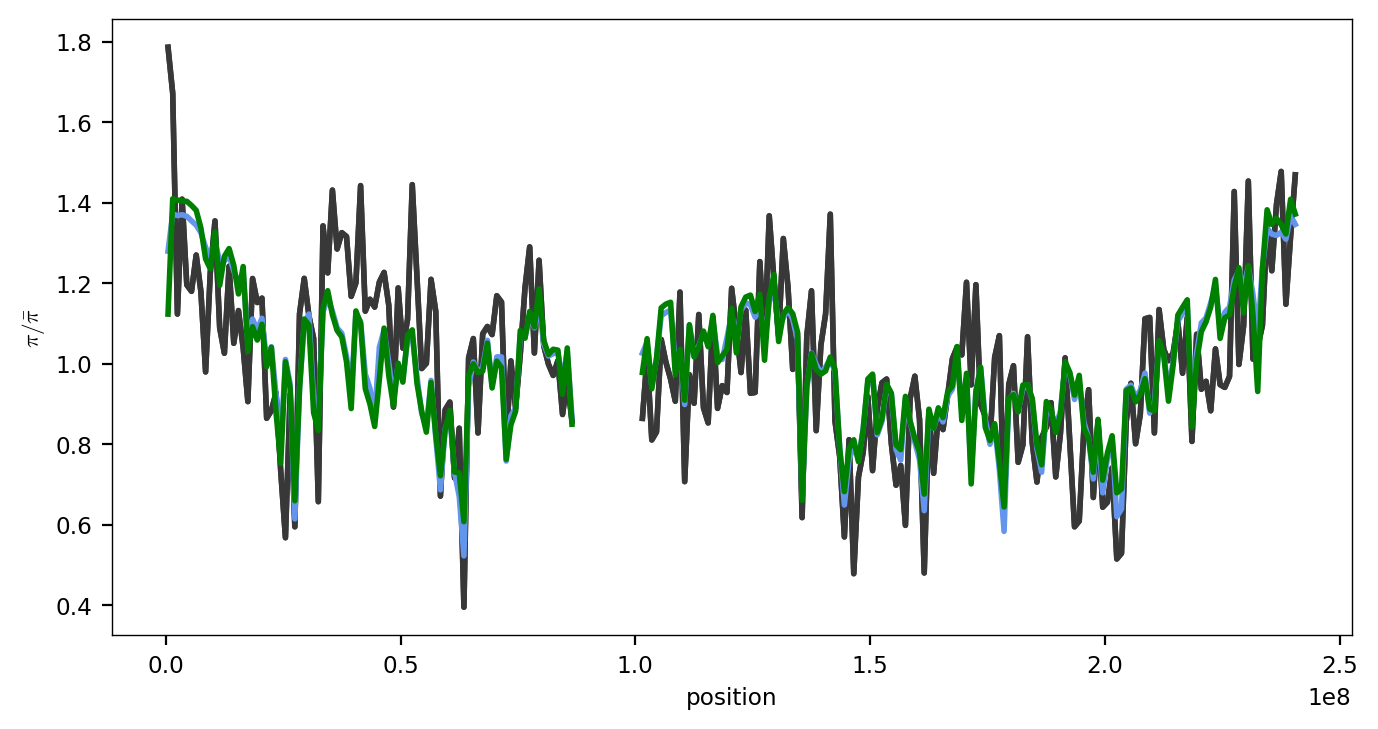

In [86]:
chrom = 'chr2'
figax = plt.subplots()
load_pickle('../mle2.pkl')['mbp'].predict_plot(chrom, figax=figax)
load_pickle('../mle.pkl')['mbp'].predict_plot(chrom, figax=figax, pred_col='g')

(<Figure size 1600x800 with 1 Axes>,
 <Axes: xlabel='predicted $\\hat{\\pi}$', ylabel='residuals'>)

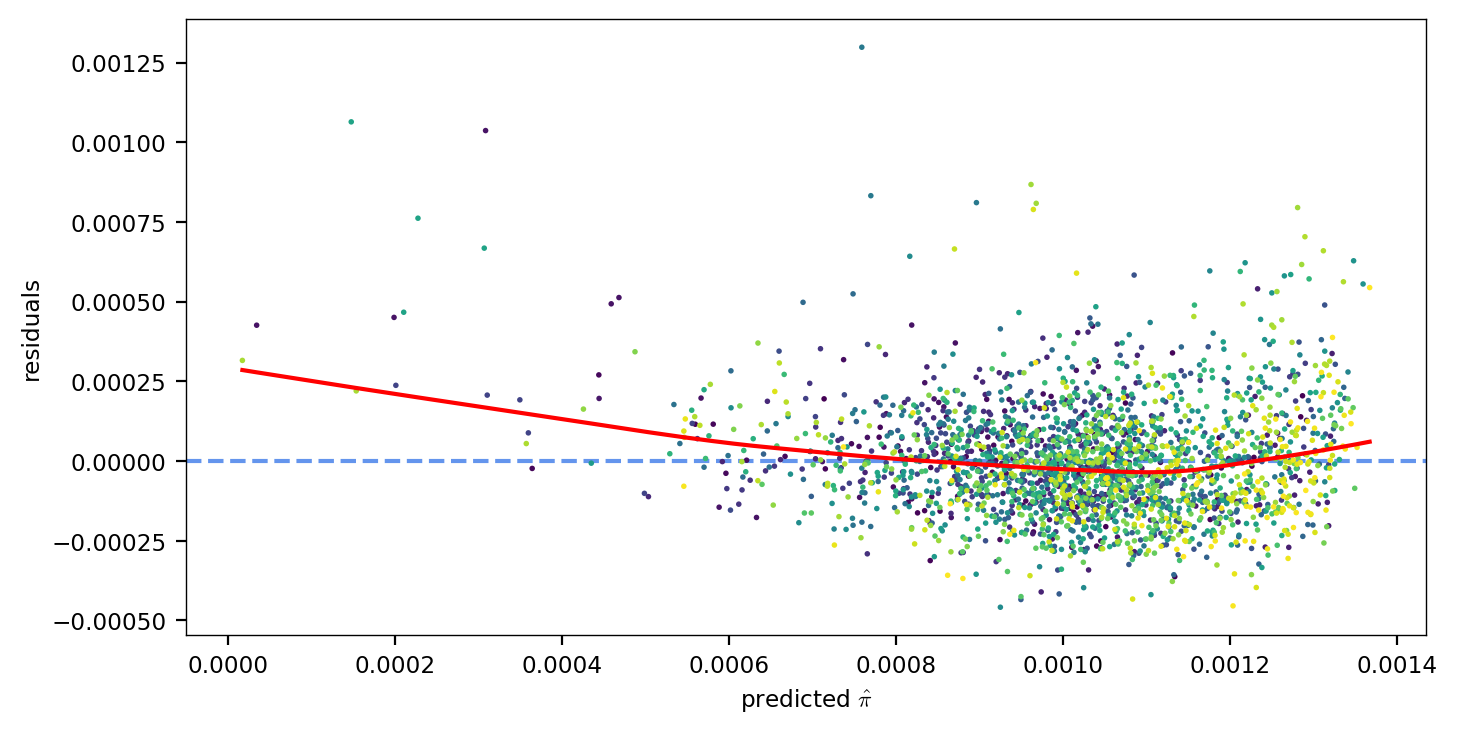

In [90]:
ff['mbp'].resid_fitted_plot()

## Data Loading

In [43]:
autosomes = [f'chr{x}' for x in range(1, 23)]
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=autosomes)
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

## Masking notes

I use the following masks:

 - **Non-"putatively" neutral masks**: masked out phastcons + genic regions, but added introns in.
 - **Accessible masks**: no centromere + some buffer around centromeres.
 - **Reference genome softmasks**: ignore softmasked regions, e.g. due to repeats.
 
More information is in the supplementary materials.

In [50]:
neutral_masks = {'old neutral': '../data/annotation/neutral_phastcons_genes_with_introns.bed.gz', 
                 'new neutral, 200bp slop': '../data/fit_annotation/putatively_neutral__slop200.bed.gz',
                 'new neutral, 100bp slop': '../data/fit_annotation/putatively_neutral__slop100.bed.gz',
                 'new neutral, no slop': '../data/fit_annotation/putatively_neutral.bed.gz',                 
                 'CADD bottom 70%': '../data/fit_annotation/cadd_bottom70_percent.bed.gz',
                }

access_masks = {#'no centro': '../data/annotation/no_centro.bed',
                'no centro, strict': '../data/annotation/no_centro_strict.bed',
                #None: None,
               }

softmasks = [True, False]

In [51]:
pis = dict()
gds_stats = dict()
bins_1Mbp = dict()

for neutral_name, neutral_mask in neutral_masks.items():
    for access_name, access_mask in access_masks.items():
        key = (neutral_name, access_name)
        gd = GenomeData(g)
        gd.load_counts_dir('../data/h1kg/hg1k_yri_counts/')
        if neutral_mask is not None:
            gd.load_neutral_masks(neutral_mask)
        if access_mask is not None:
            gd.load_accessibile_masks(access_mask)
        gd.load_fasta('../data/annotation/hg38.fa.gz', soft_mask=True)
        #gds[key] = gd
        pis[key] = gd.gwpi()
        gds_stats[key] = gd.mask_stats()
        bins_1Mbp[key] = gd.bin_pairwise_summaries(width=1e6, 
                                                  filter_neutral=True, 
                                                  filter_accessible=True,
                                                  mask_inaccessible_bins_frac=None)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [52]:
bins_1Mbp.keys()

dict_keys([('old neutral', 'no centro, strict'), ('new neutral, 200bp slop', 'no centro, strict'), ('new neutral, 100bp slop', 'no centro, strict'), ('new neutral, no slop', 'no centro, strict'), ('CADD bottom 70%', 'no centro, strict')])

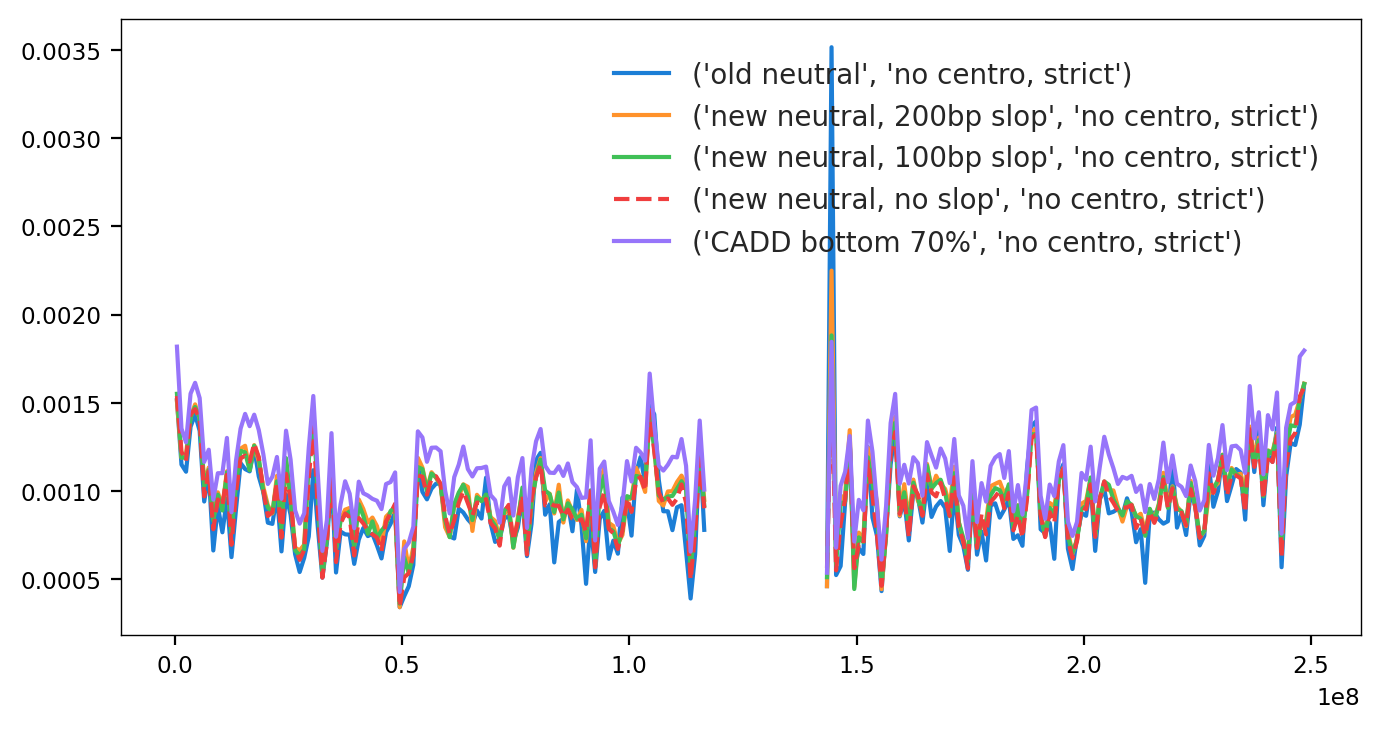

In [58]:
for key, bins in bins_1Mbp.items():
    linestyle = 'solid' if 'no slop' not in key[0] else 'dashed'
    plt.plot(*bins.pi_pairs('chr1'), label=key, linestyle=linestyle)
plt.legend()

In [60]:
for key, stats in pis.items():
    print((key, stats))

(('old neutral', 'no centro, strict'), 0.000961330717755681)
(('new neutral, 200bp slop', 'no centro, strict'), 0.001078239487525935)
(('new neutral, 100bp slop', 'no centro, strict'), 0.0010541781991546385)
(('new neutral, no slop', 'no centro, strict'), 0.001011681102734197)
(('CADD bottom 70%', 'no centro, strict'), 0.0011986728189810716)


In [59]:
for key, stats in gds_stats.items():
    print(key)
    tab = [(chrom, *row) for chrom, row in stats.items()]
    print(tabulate(tab, headers=('chrom', 'fraction accessible', 'neutral', 'both')))

('old neutral', 'no centro, strict')
chrom      fraction accessible    neutral    both
-------  ---------------------  ---------  ------
chr1                     0.397      0.644   0.216
chr2                     0.453      0.587   0.23
chr3                     0.432      0.629   0.244
chr4                     0.427      0.593   0.21
chr5                     0.424      0.58    0.206
chr6                     0.438      0.58    0.216
chr7                     0.419      0.658   0.252
chr8                     0.423      0.612   0.224
chr9                     0.362      0.645   0.19
chr10                    0.429      0.628   0.245
chr11                    0.413      0.635   0.228
chr12                    0.406      0.627   0.222
chr13                    0.388      0.62    0.179
chr14                    0.365      0.654   0.185
chr15                    0.344      0.694   0.193
chr16                    0.36       0.638   0.193
chr17                    0.372      0.64    0.207
chr18           

In [72]:
from bgspy.utils import load_pickle, mean_ratio

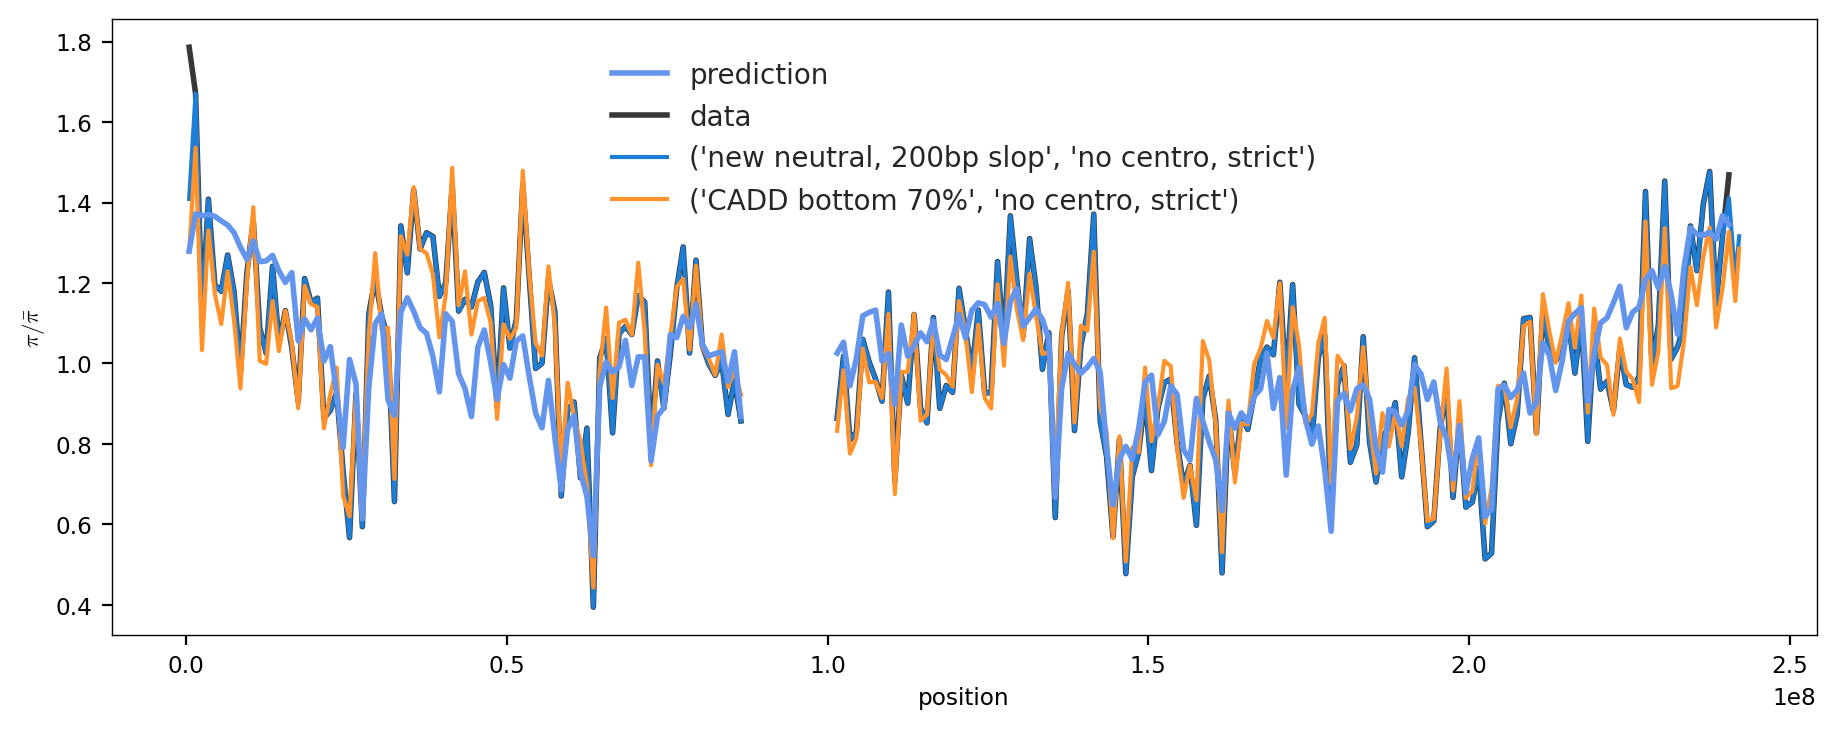

In [57]:
chrom = 'chr2'
ff = load_pickle('../new_fits/cadd6__decode/fits/pop_yri/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')
figax = plt.subplots(figsize=(11, 4))
ff['mbp'].predict_plot(chrom, figax=figax, center_scale=False)

for key, bins in bins_1Mbp.items():
    if key[0] not in ('CADD bottom 70%', 'new neutral, 200bp slop'):
        continue
    linestyle = 'solid' if 'no slop' not in key[0] else 'dashed'
    x, y= bins.pi_pairs(chrom)
    figax[1].plot(x, mean_ratio(y), label=key, linestyle=linestyle)
plt.legend()

In [61]:
ff['mbp']

/home/vsb/miniconda3/envs/bprime/lib/python3.10/site-packages/tabulate/__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (len(row) >= 1 and row[0] == SEPARATING_LINE)


SimplexModel (interpolated w): 6 x 8 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
  window size: 1.0 Mbp

ML estimates: (whole genome)
standard error method: None
negative log-likelihood: 250663447923.5791
number of successful starts: 2000 (100.0% total)
π0 = 0.00142416
π  = 0.00106447
μ_del  = 2.108e-08 
Ne = 35,603 (if μ=1e-8), Ne = 17,801 (if μ=2e-8)
R² = 68.028% (in-sample)
W = 
          cadd6
------  -------
1e-08     0.005
1e-07     0.003
1e-06     0
1e-05     0
0.0001    0.037
0.001     0.3
0.01      0.033
0.1       0.622

In [72]:
a = load_pickle('../new_fits/new_cadd6/mle.pkl')
b = load_pickle('../new_fits/cadd6__decode/fits/pop_yri/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')

In [73]:
a

/home/vsb/miniconda3/envs/bprime/lib/python3.10/site-packages/tabulate/__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (len(row) >= 1 and row[0] == SEPARATING_LINE)


{'mb': SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250663360010.81186
 number of successful starts: 2000 (100.0% total)
 π0 = 0.00142208
 π  = 0.00106447
 μ_del  = 2.072e-08 
 Ne = 35,552 (if μ=1e-8), Ne = 17,776 (if μ=2e-8)
 R² = 68.011% (in-sample)
 W = 
           cadd6
 ------  -------
 1e-08     0
 1e-07     0
 1e-06     0
 1e-05     0
 0.0001    0.031
 0.001     0.306
 0.01      0.031
 0.1       0.632,
 'mbp': SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-li

In [74]:
b

{'mb': SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250663359646.12927
 number of successful starts: 2000 (100.0% total)
 π0 = 0.00142208
 π  = 0.00106447
 μ_del  = 2.072e-08 
 Ne = 35,552 (if μ=1e-8), Ne = 17,776 (if μ=2e-8)
 R² = 68.0109% (in-sample)
 W = 
           cadd6
 ------  -------
 1e-08     0
 1e-07     0
 1e-06     0
 1e-05     0
 0.0001    0.031
 0.001     0.306
 0.01      0.031
 0.1       0.632,
 'mbp': SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-l

(<Figure size 1600x800 with 3 Axes>,
 array([<Axes: ylabel='cadd6'>, <Axes: ylabel='$\\pi_0$ ($\\times^{-3}$)'>,
        <Axes: ylabel='$\\mu$ ($\\times^{-8}$)'>], dtype=object))

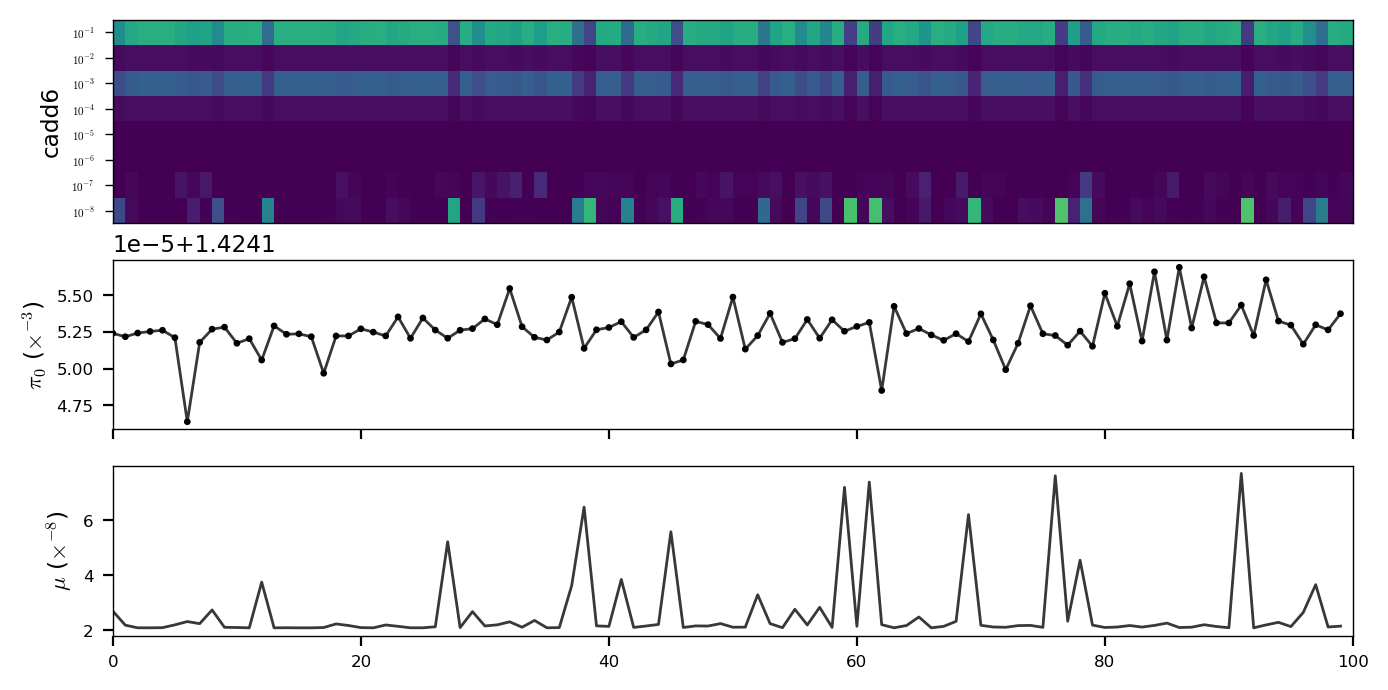

In [71]:
optim_diagnotics_plot(a)

(<Figure size 1600x800 with 3 Axes>,
 array([<Axes: ylabel='cadd6'>, <Axes: ylabel='$\\pi_0$ ($\\times^{-3}$)'>,
        <Axes: ylabel='$\\mu$ ($\\times^{-8}$)'>], dtype=object))

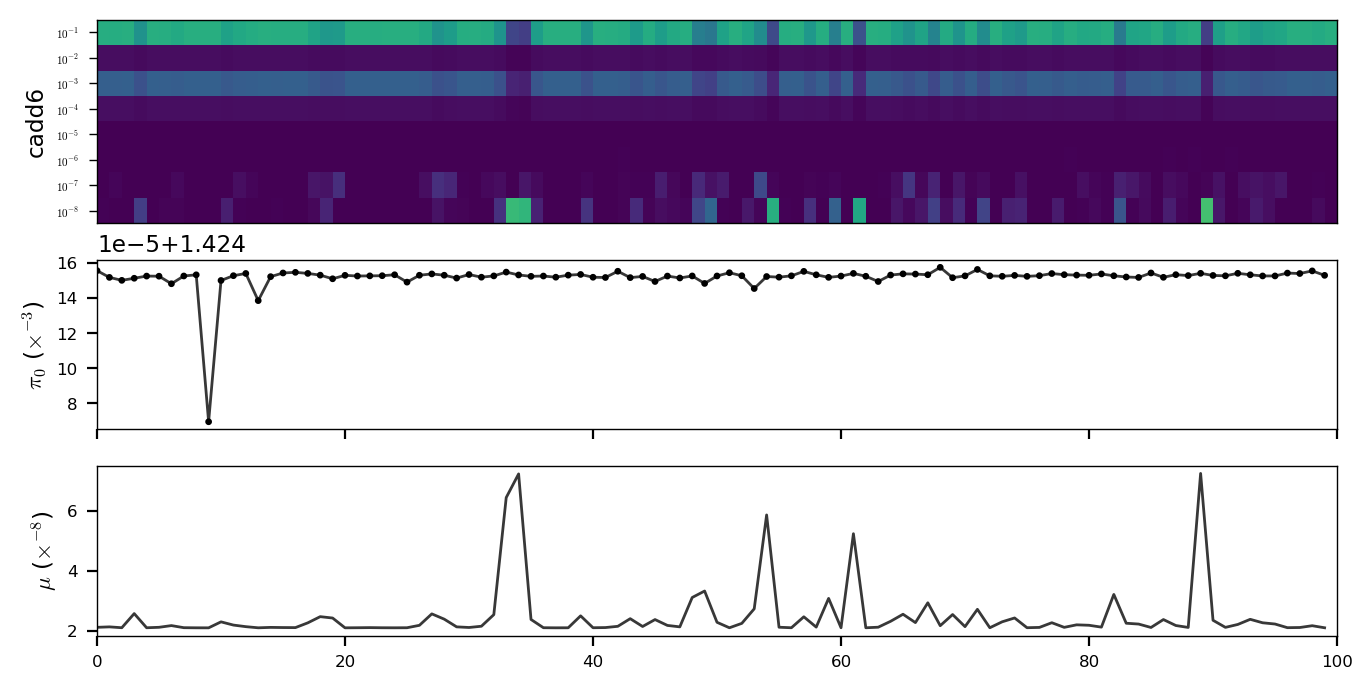

In [70]:
optim_diagnotics_plot(b)

(<Figure size 2200x800 with 1 Axes>,
 <Axes: xlabel='position', ylabel='$\\pi/\\bar{\\pi}$'>)

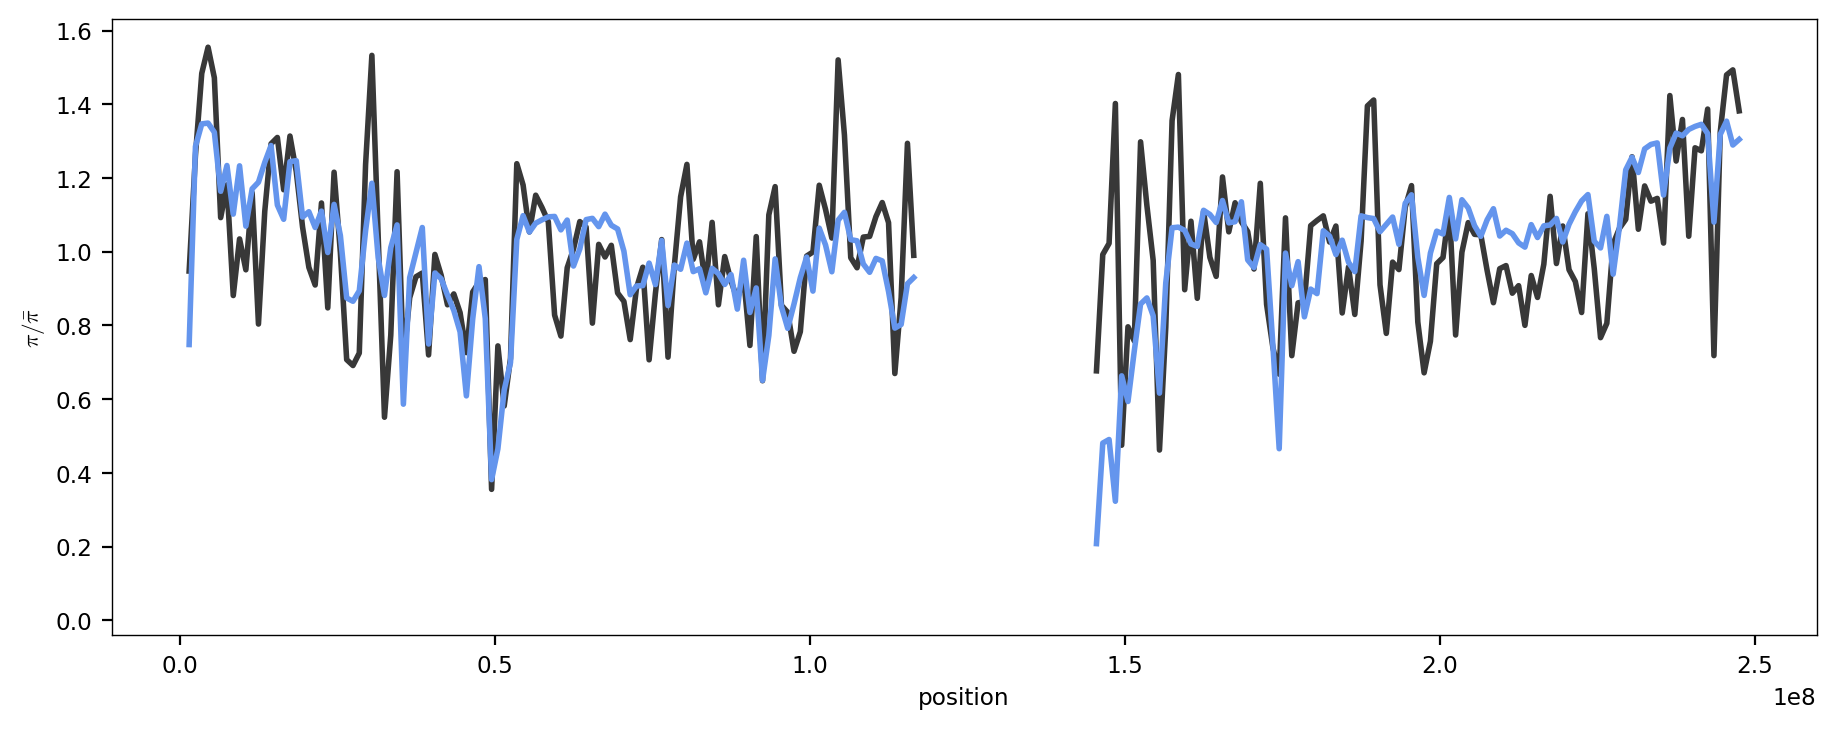

In [173]:
chrom = 'chr1'
figax = plt.subplots(figsize=(11, 4))
ff['mbp'].predict_plot(chrom, figax=figax, center_scale=False)


In [174]:
ff['mbp']

SimplexModel (interpolated w): 6 x 8 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
  window size: 1.0 Mbp

ML estimates: (whole genome)
standard error method: None
negative log-likelihood: 250663447923.5791
number of successful starts: 2000 (100.0% total)
π0 = 0.00142416
π  = 0.00106447
μ_del  = 2.108e-08 
Ne = 35,603 (if μ=1e-8), Ne = 17,801 (if μ=2e-8)
R² = 68.028% (in-sample)
W = 
          cadd6
------  -------
1e-08     0.005
1e-07     0.003
1e-06     0
1e-05     0
0.0001    0.037
0.001     0.3
0.01      0.033
0.1       0.622

In [5]:
from bgspy.utils import load_pickle

In [23]:
import pandas as pd
a = pd.read_table('../new_fits/CDS_genes_phastcons/test.pkl', sep='\t')

In [24]:
a

chrom      start        end feature         R             r  \
0        chr1          0      10000   other  0.000167  1.668076e-08   
1        chr1      10000      11873   other  0.000031  1.668076e-08   
2        chr1      11873      21873    gene  0.000167  1.668126e-08   
3        chr1      21873      29371    gene  0.000125  1.668126e-08   
4        chr1      29371      29773   other  0.000007  1.668076e-08   
...       ...        ...        ...     ...       ...           ...   
8451984  chrX  156000000  156010000   other  0.000167  1.668076e-08   
8451985  chrX  156010000  156020000   other  0.000167  1.668076e-08   
8451986  chrX  156020000  156030000   other  0.000167  1.668076e-08   
8451987  chrX  156030000  156040000   other  0.000167  1.668076e-08   
8451988  chrX  156040000  156040895   other  0.000015  1.668076e-08   

                    V            Vm  seglen  
0        1.321230e-14  1.254531e-15   10000  
1        2.474663e-15  2.349736e-16    1873  
2        6.398872e-07  6.398803e-08   10000  
3        4.797875e-07  4.797823e-08    7498  
4        5.311343e-16  5.043214e-17     402  
...               ...           ...     ...  
8451984  1.321230e-14  1.254531e-15   10000  
8451985  1.321230e-14  1.254531e-15   10000  
8451986  1.321230e-14  1.254531e-15   10000  
8451987  1.321230e-14  1.254531e-15   10000  
8451988  1.182500e-15  1.122805e-16     895  

[8451989 rows x 9 columns]

In [41]:
load_pickle('../new_fits/CDS_genes_phastcons

FileNotFoundError: [Errno 2] No such file or directory: '../new_fits/CDS_genes_phastcons/pop_yri/window_1000000/type_full/mutrate_free/initial/mle.pkl'

In [26]:
a.groupby(('feature')).mean('r')

start           end             R             r  \
feature                                                             
CDS        7.560851e+07  7.560865e+07  3.142841e-06  2.188767e-08   
gene       7.811121e+07  7.811191e+07  1.169629e-05  1.668126e-08   
other      8.092667e+07  8.092704e+07  6.147843e-06  1.668076e-08   
phastcons  8.250113e+07  8.250115e+07  7.524401e-11  4.325165e-12   

                      V            Vm      seglen  
feature                                            
CDS        1.103413e-06  1.103365e-07  143.581410  
gene       4.486654e-08  4.486606e-09  701.163266  
other      4.869508e-16  4.623685e-17  368.558840  
phastcons  1.292120e-17  1.292089e-18   17.396795

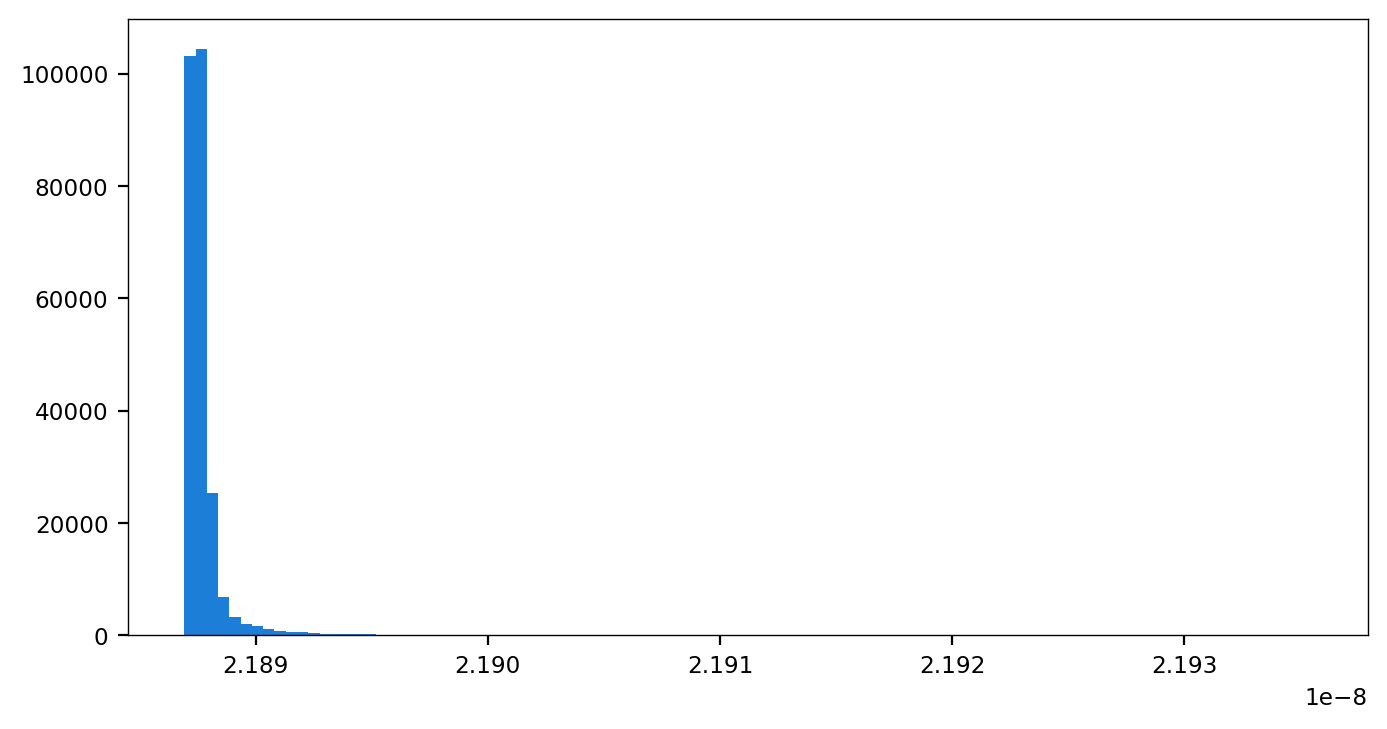

In [37]:
_ = plt.hist(a.loc[a['feature'] == 'CDS']['r'], 100)
#_ = plt.hist(a.loc[a['feature'] == 'CDS']['r'], 100)

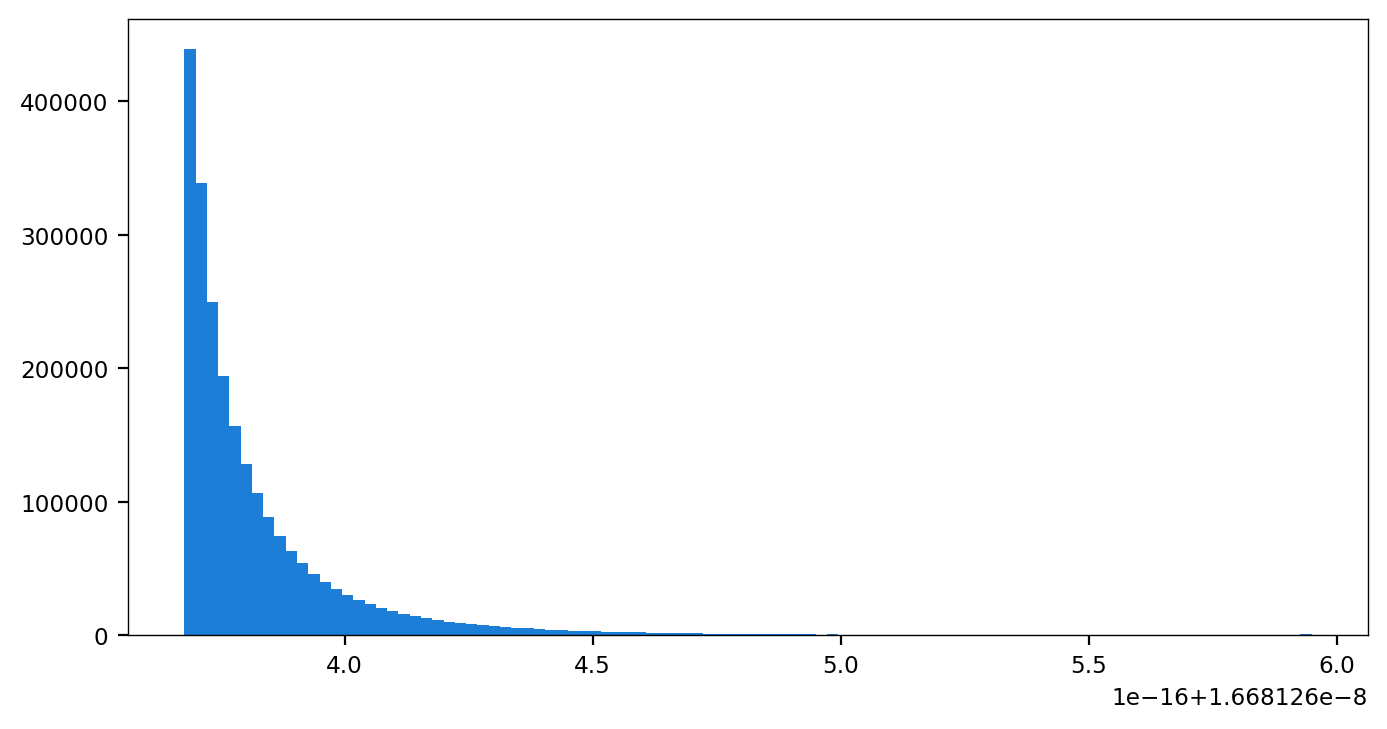

In [38]:
_ = plt.hist(a.loc[a['feature'] == 'gene']['r'], 100)

In [32]:
z['R'] / z['seglen']

feature
CDS          2.188891e-08
gene         1.668126e-08
other        1.668076e-08
phastcons    4.325165e-12
dtype: float64

(array([2259876.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 6192113.]),
 array([-11.36399735, -10.9934829 , -10.62296845, -10.25245401,
         -9.88193956,  -9.51142511,  -9.14091066,  -8.77039622,
         -8.39988177,  -8.02936732,  -7.65885288]),
 <BarContainer object of 10 artists>)

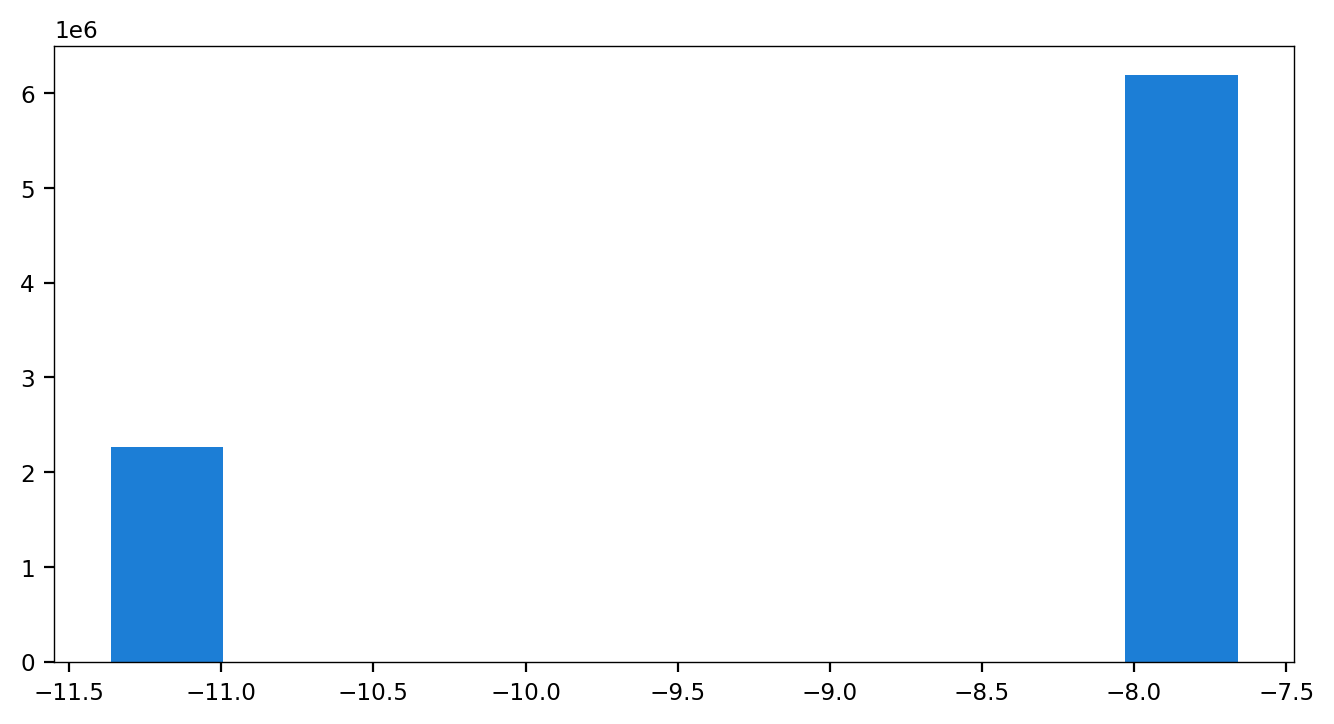

In [28]:
plt.hist(np.log10(a['r']))

In [33]:
load_pickle('../new_fits/CDS_genes_phastcons__decode/fits/pop_yri/window_1000000/type_full//mutrate_free/initial/mle.pkl')

/home/vsb/miniconda3/envs/bprime/lib/python3.10/site-packages/tabulate/__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (len(row) >= 1 and row[0] == SEPARATING_LINE)


{'mb': SimplexModel (interpolated w): 6 x 8 x 4
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250715657167.8578
 number of successful starts: 2000 (100.0% total)
 π0 = 0.00150476
 π  = 0.00106447
 μ_del  = 1.621e-09 
 Ne = 37,618 (if μ=1e-8), Ne = 18,809 (if μ=2e-8)
 R² = 61.3293% (in-sample)
 W = 
           CDS    gene    other    phastcons
 ------  -----  ------  -------  -----------
 1e-08       0   0            0        0
 1e-07       0   0            0        0
 1e-06       0   0            0        0
 1e-05       0   0            0        0.163
 0.0001      0   0            0        0.837
 0.001       1   0.458        0        0
 0.01        0   0            0        0
 0.1         0   0.542        1        0,
 'mbp': SimplexModel (interpolated w): 6 x 

In [148]:
from bgspy.utils import phred, bin_chrom
cd = np.load('../data/fit_annotation/cadd_whole_genome_SNVs.npz')

In [150]:
bins = bin_chrom(sl['chr1'], 1e6)

In [151]:
from scipy.stats import binned_statistic

In [153]:
neut_bins = binned_statistic(np.arange(cd['chr1'].shape[0]), cd['chr1'] < phred(0.3), bins=bins, statistic=np.nanmean)

KeyboardInterrupt: 

In [166]:
x = cd['chr1'] < phred(1-0.3)

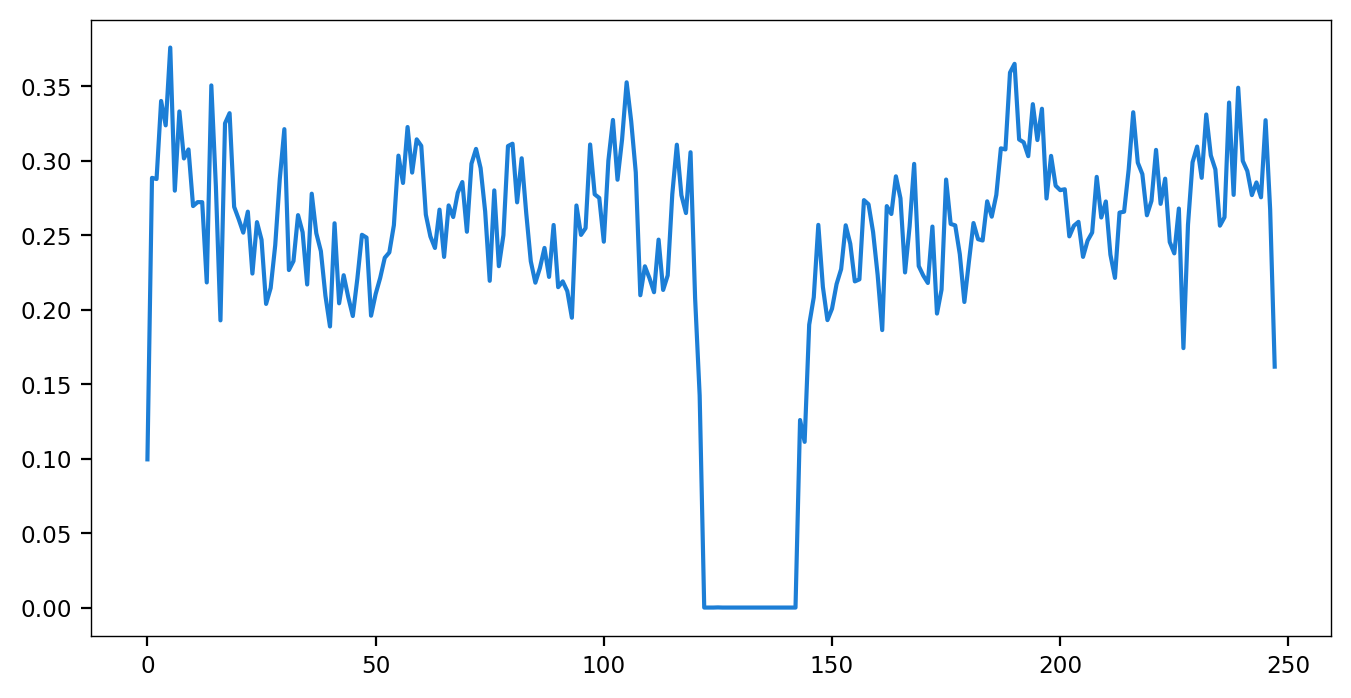

In [167]:
plt.plot(np.nanmean(x[:int(1e6 * 248)].reshape((-1, 1_000_000)), axis=1))

In [ ]:
neut_bins

In [147]:
phred(0.3)

5.228787452803376

In [129]:
ff['mbp']

/home/vsb/miniconda3/envs/bprime/lib/python3.10/site-packages/tabulate/__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (len(row) >= 1 and row[0] == SEPARATING_LINE)


SimplexModel (interpolated w): 6 x 8 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
  window size: 1.0 Mbp

ML estimates: (whole genome)
standard error method: None
negative log-likelihood: 250663447923.5791
number of successful starts: 2000 (100.0% total)
π0 = 0.00142416
π  = 0.00106447
μ_del  = 2.108e-08 
Ne = 35,603 (if μ=1e-8), Ne = 17,801 (if μ=2e-8)
R² = 68.028% (in-sample)
W = 
          cadd6
------  -------
1e-08     0.005
1e-07     0.003
1e-06     0
1e-05     0
0.0001    0.037
0.001     0.3
0.01      0.033
0.1       0.622

(<Figure size 2200x1000 with 1 Axes>,
 <Axes: xlabel='position', ylabel='$\\pi/\\bar{\\pi}$'>)

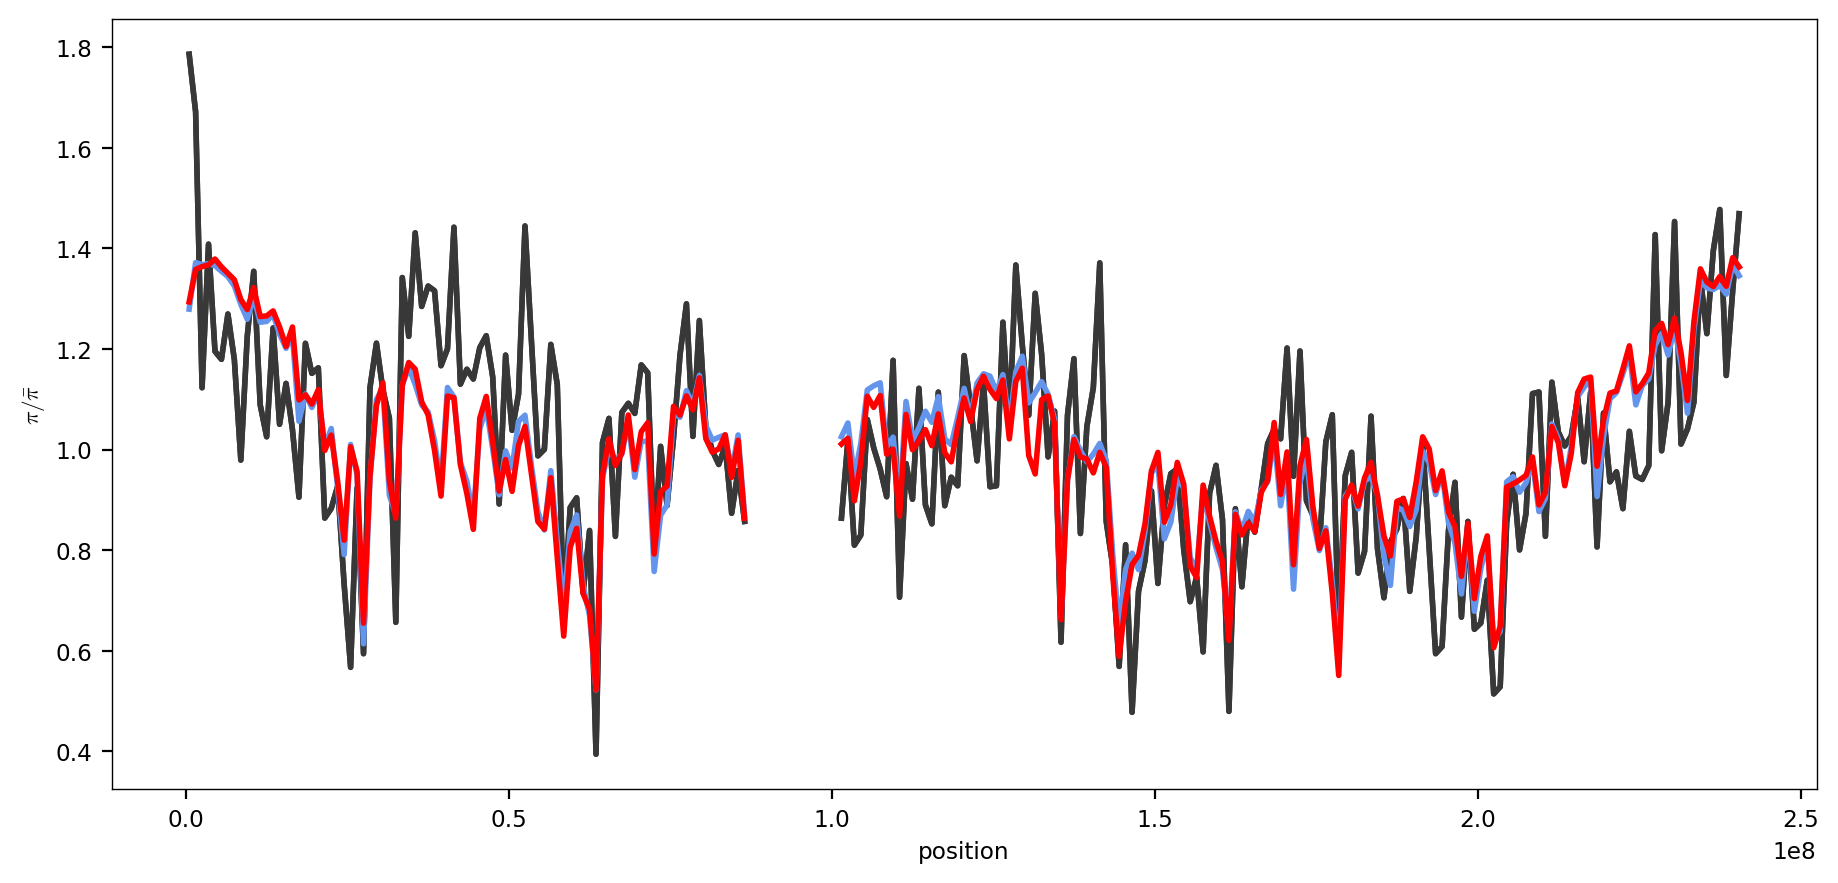

In [178]:
chrom = 'chr2'
ff2 = load_pickle('../new_fits/phastcons_CDS_genes__decode/fits/pop_yri/window_1000000/type_full/mutrate_free/initial/mle.pkl')
figax = plt.subplots(figsize=(11, 5))
ff['mbp'].predict_plot(chrom, figax=figax)
ff2['mbp'].predict_plot(chrom, figax=figax, center_scale=False, pred_col='r')


(<Figure size 2200x1000 with 1 Axes>,
 <Axes: xlabel='position', ylabel='$\\pi/\\bar{\\pi}$'>)

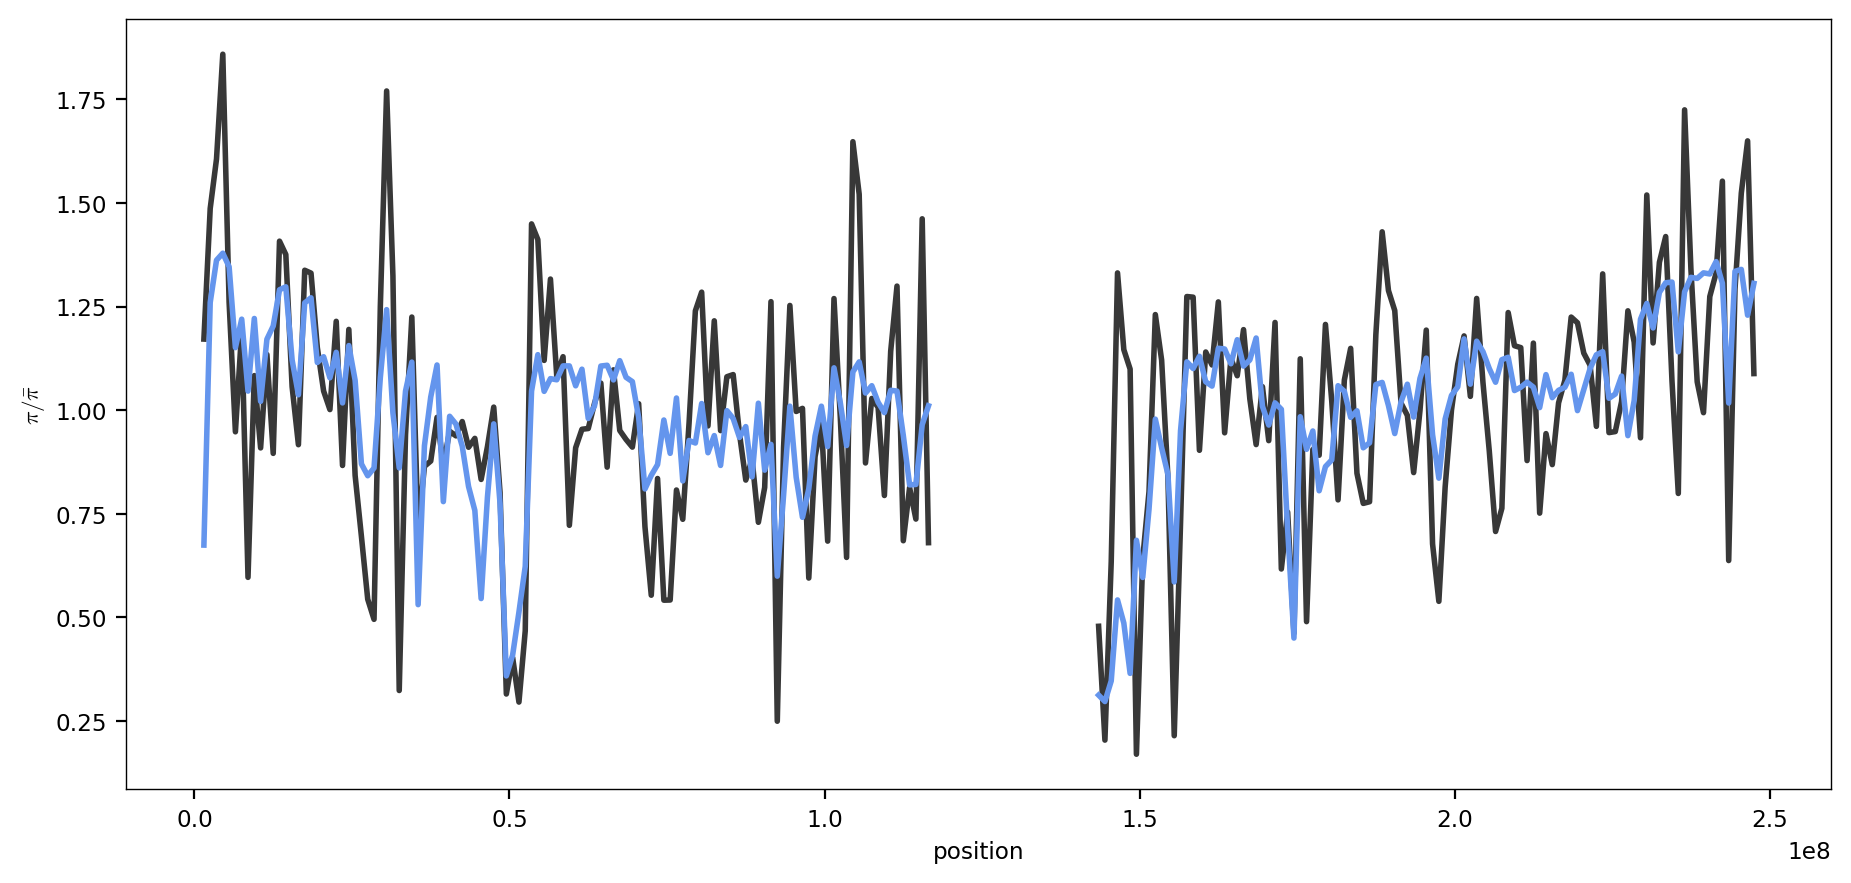

In [136]:
ff = load_pickle('../new_fits/phastcons_CDS_genes__decode/fits/pop_chb/window_1000000/type_full/mutrate_free/initial/mle.pkl')
figax = plt.subplots(figsize=(11, 5))
ff['mbp'].predict_plot('chr1', figax=figax)

In [37]:
ff['mbp']

/home/vsb/miniconda3/envs/bprime/lib/python3.10/site-packages/tabulate/__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (len(row) >= 1 and row[0] == SEPARATING_LINE)


SimplexModel (interpolated w): 6 x 8 x 4
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
  window size: 1.0 Mbp

ML estimates: (whole genome)
standard error method: None
negative log-likelihood: 250656993728.51846
number of successful starts: 2000 (100.0% total)
π0 = 0.0014725
π  = 0.00106447
μ_del  = 1.704e-08 
Ne = 36,812 (if μ=1e-8), Ne = 18,406 (if μ=2e-8)
R² = 68.1221% (in-sample)
W = 
          CDS    gene    other    phastcons
------  -----  ------  -------  -----------
1e-08       1   0.905    0.976        0
1e-07       0   0        0.002        0.003
1e-06       0   0        0            0
1e-05       0   0.04     0            0
0.0001      0   0        0            0
0.001       0   0        0            0.527
0.01        0   0        0            0.208
0.1         0   0.055    0.021        0.261

(<Figure size 1600x800 with 6 Axes>,
 array([<Axes: ylabel='CDS'>, <Axes: ylabel='gene'>,
        <Axes: ylabel='other'>, <Axes: ylabel='phastcons'>,
        <Axes: ylabel='$\\pi_0$ ($\\times^{-3}$)'>,
        <Axes: ylabel='$\\mu$ ($\\times^{-8}$)'>], dtype=object))

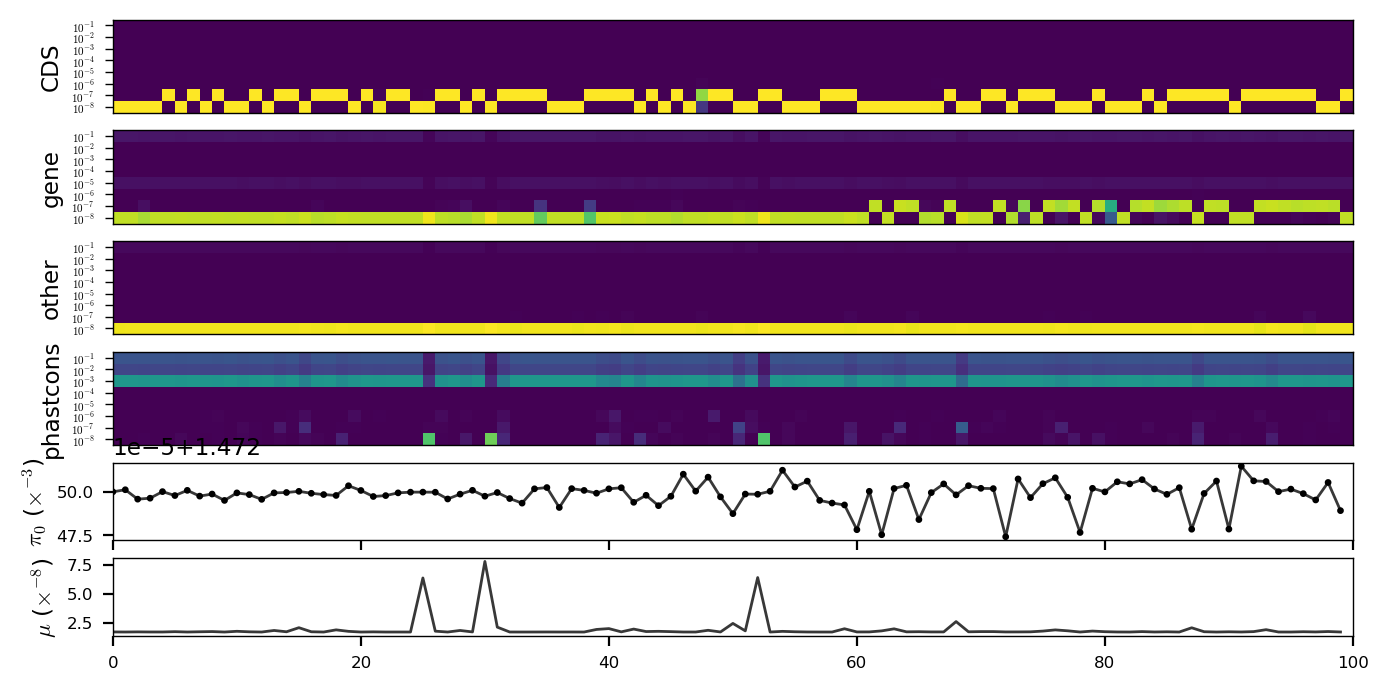

In [140]:
from bgspy.optim import optim_diagnotics_plot
optim_diagnotics_plot(ff2['mbp'])

In [78]:
from bgspy.data import CountsDirectory, pi_from_pairwise_summaries, pairwise_summary

d = CountsDirectory('../data/h1kg/hg1k_yri_counts', lambda x: x.split('_')[0])

In [80]:
sliding_window_view = np.lib.stride_tricks.sliding_window_view

In [100]:
from bgspy.utils import read_bed3, load_seqlens
access = read_bed3('../data/annotation/no_centro_strict.bed')
sl = load_seqlens('../data/fit_annotation/hg38_seqlens.tsv')

In [98]:
from bgspy.utils import ranges_to_masks

In [102]:
msk = ranges_to_masks(access, sl)

In [108]:
msk['chr1'].mean()

0.7081002393262223

In [109]:
yy = pairwise_summary(d['chr1'])
pi = pi_from_pairwise_summaries(yy * msk['chr1'][:, None])

pis = sliding_window_view(pi, int(2e6), axis=0)

/tmp/ipykernel_66173/3147443582.py:4: RuntimeWarning: Mean of empty slice
  ax.plot(np.arange(pis.shape[0])[::step], mean_ratio(np.nanmean(pis[::step], axis=1)), color='orange')


(<Figure size 1600x800 with 1 Axes>,
 <Axes: xlabel='position', ylabel='$\\pi/\\bar{\\pi}$'>)

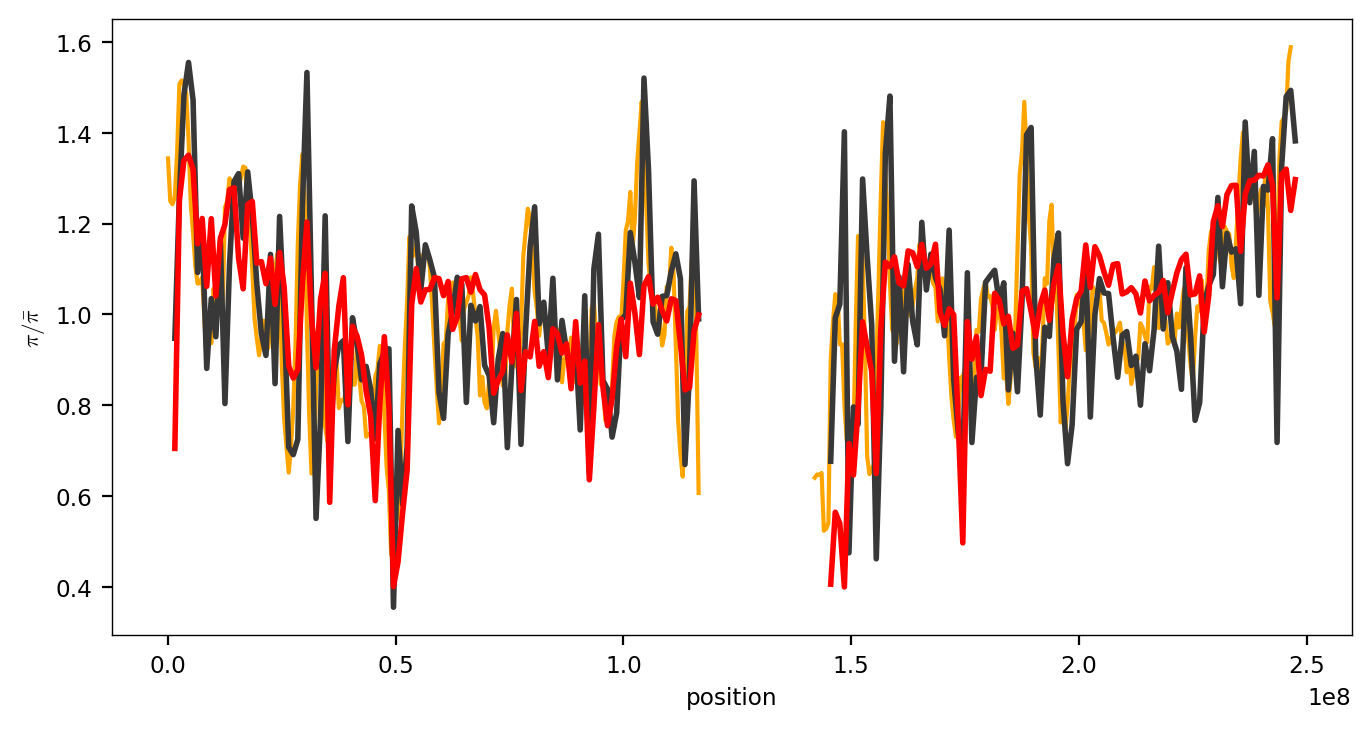

In [116]:
step = 500_000

fig, ax = plt.subplots()
ax.plot(np.arange(pis.shape[0])[::step], mean_ratio(np.nanmean(pis[::step], axis=1)), color='orange')
ff['mbp'].predict_plot('chr1', ratio=True, figax=(fig, ax), alpha_pi=1, alpha_predict=1, pred_col='r')
#ax.set_ylim(0.000, 2)

In [89]:
np.array([2.1]).nbytes

8

In [92]:
3 * 6 * 8 * 50528855 * 8

58209240960

## TODO HERE

Let's output the **soft-masked** version as a supplementary table (perhaps just in GH repo):

In [17]:
mstats_tab = [{'chrom': c, 'accessible': 100*a, 'neutral': 100*n, 'both': 100*b, 
              #'basepairs':  int(g.seqlens[c]*b)
              } for
              c, (a, n, b) in gd.mask_stats().items()]
mstats_df = pd.DataFrame(mstats_tab)
mstats_df.to_csv('../data/supplementary_data/accessibilty.tsv', sep='\t', index=False)
mstats_df.head()

chrom  accessible  neutral  both
0  chr1        42.4     64.4  22.9
1  chr2        46.8     58.7  23.7
2  chr3        44.1     62.9  24.8
3  chr4        44.0     59.3  21.5
4  chr5        44.1     58.0  21.4

In [18]:
# uncomment and run for supplementary table
# print(mstats_df.to_latex(index=False))

## Genome-wide Diversity

This is mostly validation of my functions to calculate $\pi$.


### Sample Details
 
My sample came from a different project that didn't work out — it was originally CEU, CHB, and YRI samples from the dataset; 460 total. The underlying data is the 1000 Genomes [30x on GRCh38 dataset](https://www.internationalgenome.org/data-portal/data-collection/30x-grch38), of which there are 178 total YRI individuals.

The samples are in `../data/h1kg/yri_samples.tsv`.

Let's validate for chr1 counts of alleles that we have less than diploid individuals:

In [20]:
# not checked in to GH due to size
counts_chr1 = np.load('../data/h1kg/hg1k_yri_counts//chr1_counts.npy')
counts_chr1.sum(axis=1).max() / 2

178.0

Looks good — my raw data is the complete YRI sample.

### Validation of Diversity

First, let's evaluate and do some validation for my methods for calculating genome-wide diversity in this sample.

The likelihood methods use binned allele counts, summed across all sites in the bin. These should be invariant to the bin width. So I check this below, looking at binned diversity at the megabase and 100kbp scales. Bins with high levels of inaccessible bases (`mask_inaccessible_bins_frac`) are *not* masked here, just for validation.

NOTE: I also ran checks againt scikit-allel, but a numpy upgrade deprecated a function, and this broke scikit-allel (which hasn't been updated in ages). Unfortunately, I had to remove those tests
from this notebook because of sckit-allel.

### Windowed diversity 

In [21]:
bins_1Mbp = gd.bin_pairwise_summaries(width=1e6, 
                                      filter_neutral=True, 
                                      filter_accessible=True,
                                      mask_inaccessible_bins_frac=None)

  0%|          | 0/22 [00:00<?, ?it/s]

In [25]:
bins_1Mbp_alt = gd_alt.bin_pairwise_summaries(width=1e6, 
                                      filter_neutral=True, 
                                      filter_accessible=True,
                                      mask_inaccessible_bins_frac=None)

  0%|          | 0/22 [00:00<?, ?it/s]

In [22]:
bins_1Mbp_nosm = gd_nosm.bin_pairwise_summaries(width=1e6, 
                                                filter_neutral=True, 
                                                filter_accessible=True,
                                                mask_inaccessible_bins_frac=None)

  0%|          | 0/22 [00:00<?, ?it/s]

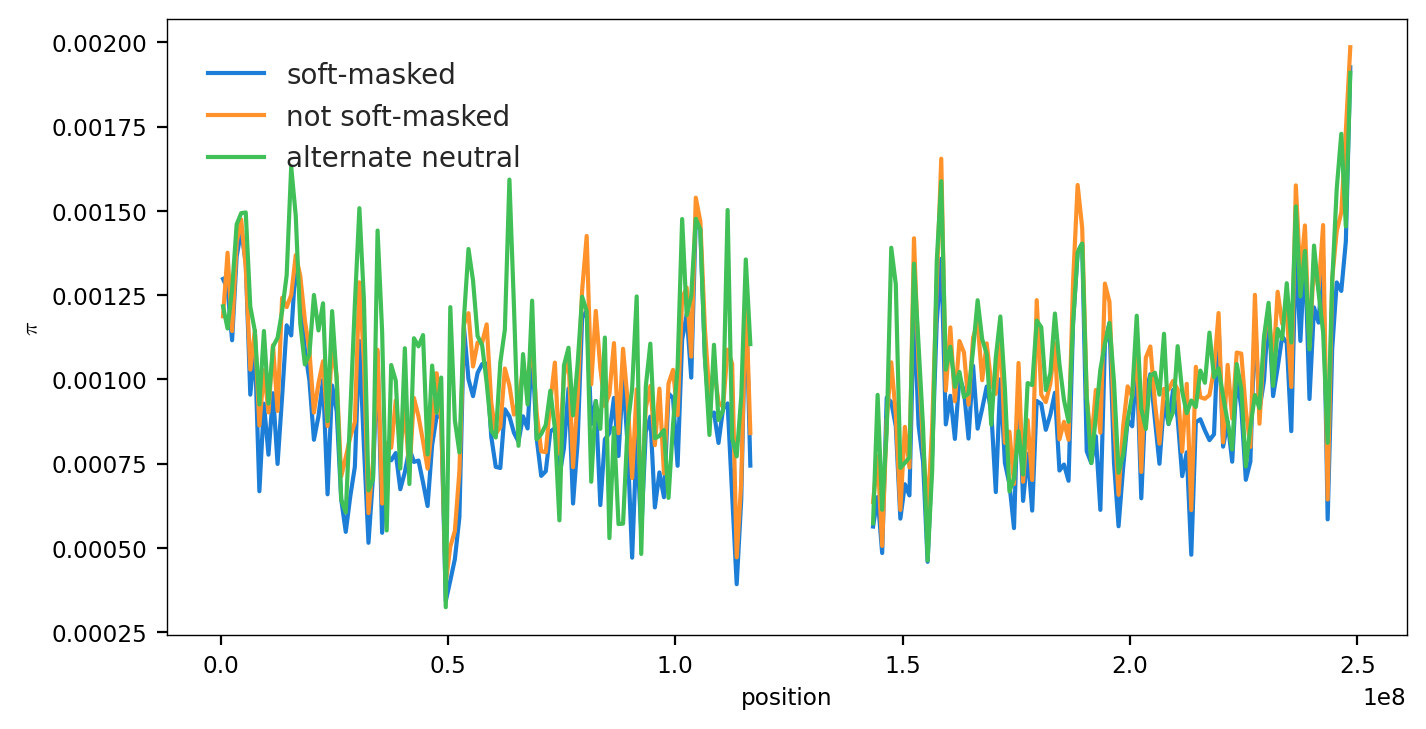

In [28]:
plt.plot(*bins_1Mbp.pi_pairs('chr1'), label='soft-masked')
plt.plot(*bins_1Mbp_nosm.pi_pairs('chr1'), label='not soft-masked')
plt.plot(*bins_1Mbp_alt.pi_pairs('chr1'), label='alternate neutral')
plt.ylabel('$\pi$')
plt.xlabel('position')
plt.legend()

In [ ]:
bins_100kbp = gd.bin_pairwise_summaries(width=1e5, 
                                        filter_neutral=True, 
                                        filter_accessible=True,
                                        mask_inaccessible_bins_frac=None)

In [17]:
# verify that no windows are masked (we set mask_inaccessible_bins_frac = None and not
# outlier based filtering has been applied)
assert(bins_1Mbp.Y(filter_masked=True).mean() == bins_1Mbp.Y(filter_masked=False).mean())

In [18]:
# calculate the Y matrices, which are binned sums of allele counts
Y_1Mbp = bins_1Mbp.Y()
Y_100kbp = bins_100kbp.Y()

In [19]:
# naive unweighted sum -- this does not weight diversity
# in windows by their size of accessible bases 
np.nanmean(pi_from_pairwise_summaries(Y_1Mbp)), np.nanmean(pi_from_pairwise_summaries(Y_100kbp)), 

(0.000969438259704129, 0.001005023078100236)

These don't match — but that is expected, since the unweighted mean is taken.

If instead we sum all columns, then calculate pairwise diversity, no information is lost:

In [20]:
pi_from_pairwise_summaries(Y_1Mbp.sum(axis=0)), pi_from_pairwise_summaries(Y_100kbp.sum(axis=0))

(0.0009732149776103245, 0.0009732149776103245)

Which gives us identical values as expected.

Now, let's look at the genome-wide average in accessible putatively neutral regions.

In [21]:
gw_yri = gd.gwpi(filter_neutral=True, filter_accessible=True)

  0%|          | 0/22 [00:00<?, ?it/s]

In [22]:
gw_yri

0.0009732149776103245

In [23]:
gw_yri_sample_weight = gd.gwpi(filter_neutral=True, filter_accessible=True, weight_pairwise=False)

  0%|          | 0/22 [00:00<?, ?it/s]

In [24]:
gw_yri_sample_weight

0.0009733107996355531

In [25]:
keep = (Y_1Mbp > 0).all(axis=1)
keep.mean()

pi_from_pairwise_summaries(Y_1Mbp[keep].sum(axis=0)), pi_from_pairwise_summaries(Y_1Mbp.sum(axis=0))

(0.0009732149776103245, 0.0009732149776103245)

So these are identical (this is a check). The underlying issue seems to be a floating point issue with the numeric averaging. I would trust this estimate.

In [26]:
# what's the relative error between binned averages and genome-wide?

rel_error(gw_yri, pi_from_pairwise_summaries(Y_1Mbp.sum(axis=0)))

0.0

Note, there is some small ~0.009% relative error between binning and the full genome-approach based on weighting chromosomes. This is from unknown numeric issues, but is such a small scale that we can ignore it.

Now, let's look at diversity across each chromosome separately.

In [27]:
pi_chroms = gd.pi(filter_neutral=True, filter_accessible=True)

  0%|          | 0/22 [00:00<?, ?it/s]

In [28]:
# pi_chrom genome-wide
pi_ests = np.array(list(pi_chroms[0].values())).flat
np.average(pi_ests, weights=list(pi_chroms[1].values()))

0.0009732149776103245

This agrees with the `gd.pi()` estimates (as it should, since it's doing the same weighted average internally). But note that this differs slightly from the binned average as mentioned above.

## Sensitivity to Various Filters

Compare that to the value without filtering based on accessibility only, not putatively neutral.

In [29]:
gw_yri_accessible_only = gd.gwpi(filter_neutral=False, filter_accessible=True)
gw_yri_accessible_only

  0%|          | 0/22 [00:00<?, ?it/s]

0.00097996120737887

What if we don't filter at all? The estimate is much higher:

In [30]:
gw_yri_unfiltered = gd.gwpi(filter_neutral=False, filter_accessible=False)
gw_yri_unfiltered

  0%|          | 0/22 [00:00<?, ?it/s]

0.0010820955264241178

In [31]:
bins_1Mbp_accessible_only = gd.bin_pairwise_summaries(width=1e6, 
                                      filter_neutral=False, 
                                      filter_accessible=True,
                                      mask_inaccessible_bins_frac=None)
bins_1Mbp_unfiltered = gd.bin_pairwise_summaries(width=1e6, 
                                      filter_neutral=False, 
                                      filter_accessible=False,
                                      mask_inaccessible_bins_frac=None)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [32]:
fig_sizes.keys()

dict_keys([('one', 'golden'), ('one', 'one'), ('one', 'two'), ('onehalf', 'golden'), ('onehalf', 'one'), ('onehalf', 'two'), ('two', 'golden'), ('two', 'one'), ('two', 'two')])

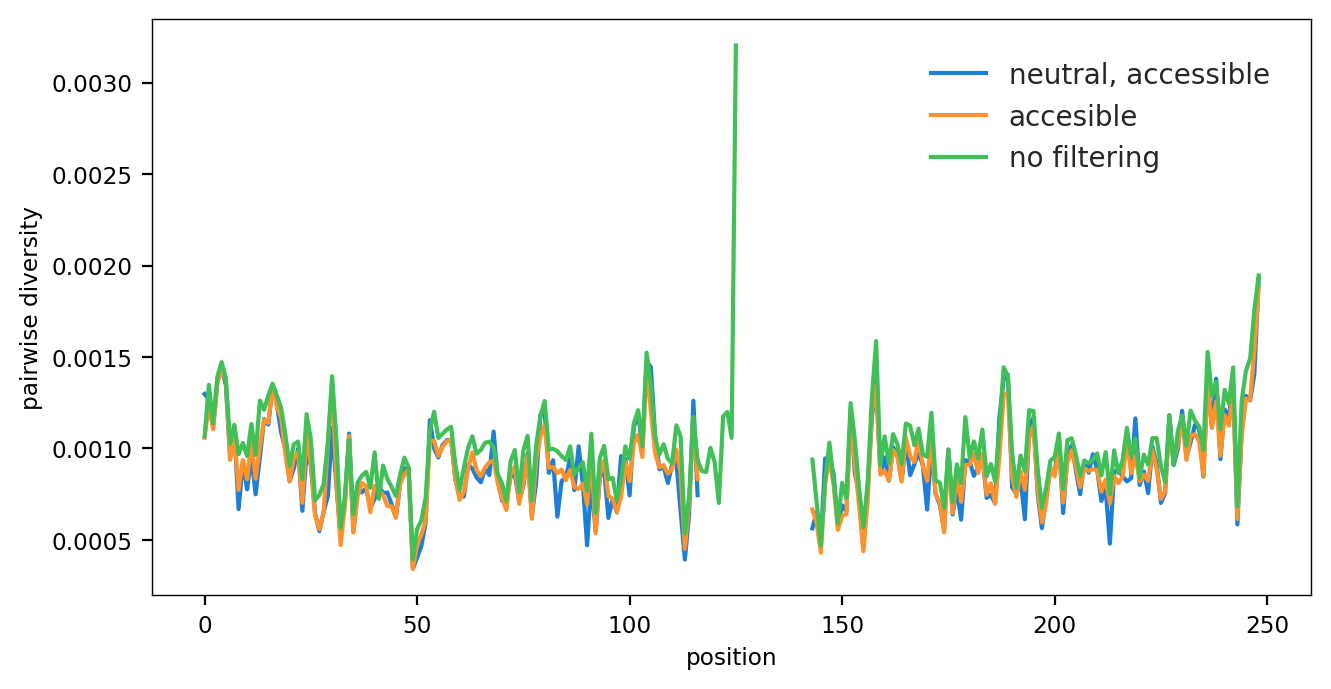

In [33]:
fig, ax = plt.subplots(figsize=fig_sizes[('two', 'two')])
idx = bins_1Mbp.chrom_indices('chr1')

pi_chr1_filtered = pi_from_pairwise_summaries(bins_1Mbp.Y()[idx, :])
pi_chr1_accessible_only = pi_from_pairwise_summaries(bins_1Mbp_accessible_only.Y()[idx, :])
pi_chr1_no_filtering = pi_from_pairwise_summaries(bins_1Mbp_unfiltered.Y()[idx, :])
ax.plot(pi_chr1_filtered, label='neutral, accessible')
ax.plot(pi_chr1_accessible_only, label='accesible')
ax.plot(pi_chr1_no_filtering, label='no filtering')
ax.set_ylabel('pairwise diversity')
ax.set_xlabel('position')
#ax.grid()
ax.legend()
plt.savefig(os.path.join(FIGDIR, 'supplementary', 'chr1_diversity_filtering.pdf'))

(0.0002, 0.002)

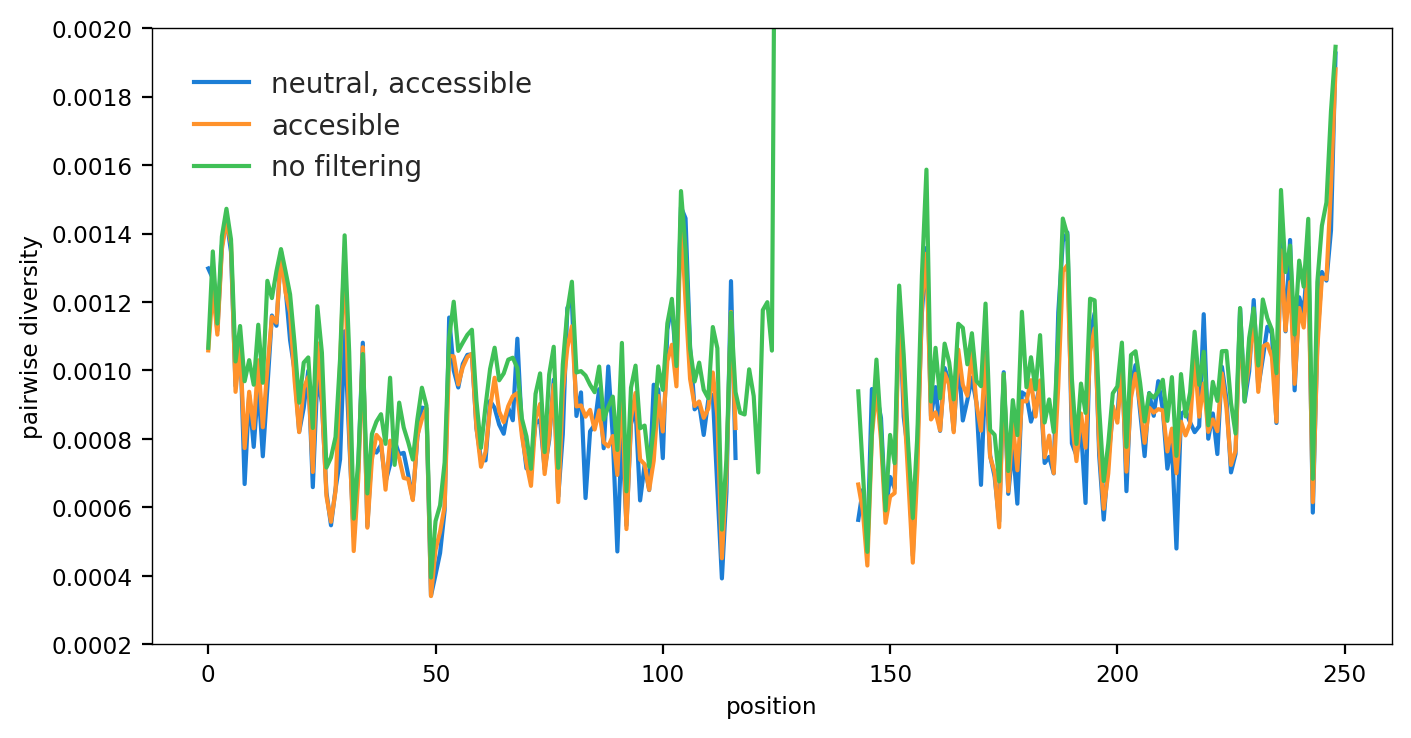

In [34]:
idx = bins_1Mbp.chrom_indices('chr1')

pi_chr1_filtered = pi_from_pairwise_summaries(bins_1Mbp.Y()[idx, :])
pi_chr1_accessible_only = pi_from_pairwise_summaries(bins_1Mbp_accessible_only.Y()[idx, :])
pi_chr1_no_filtering = pi_from_pairwise_summaries(bins_1Mbp_unfiltered.Y()[idx, :])
plt.plot(pi_chr1_filtered, label='neutral, accessible')
plt.plot(pi_chr1_accessible_only, label='accesible')
plt.plot(pi_chr1_no_filtering, label='no filtering')
plt.ylabel('pairwise diversity')
plt.xlabel('position')
plt.legend()
plt.ylim(0.0002, 0.002)

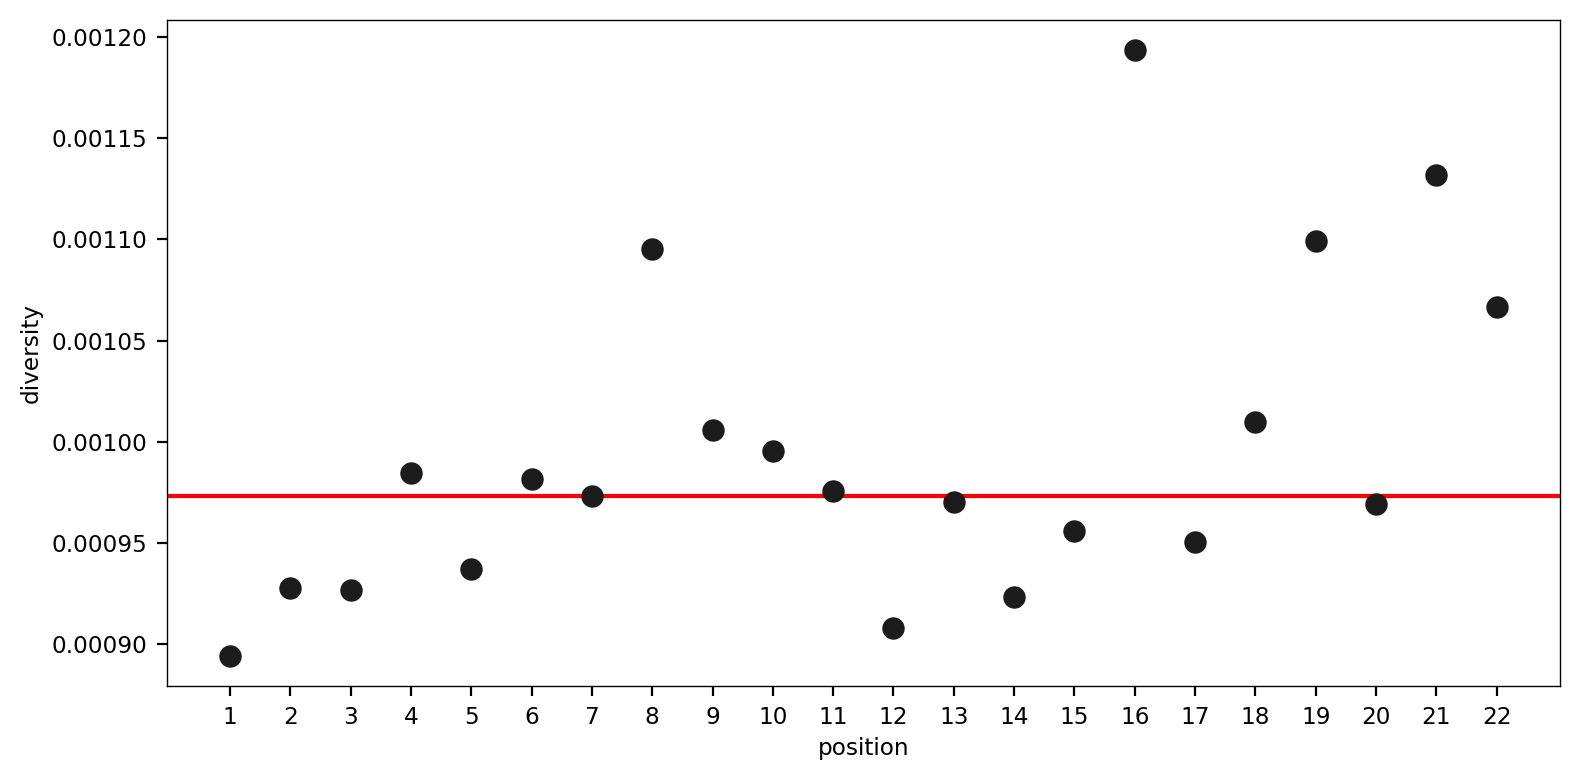

In [35]:
plt.scatter([x.replace('chr', '') for x in pi_chroms[0].keys()], pi_chroms[0].values(),
            c='0.11', s=50)
plt.axhline(gw_yri, c='r', zorder=-1)
plt.ylabel('diversity')
plt.xlabel('position')
plt.tight_layout()

In [36]:
# make a version for trimming specifically
bins_1Mbp_trimmed = gd.bin_pairwise_summaries(width=1e6, 
                                              filter_neutral=True, 
                                              filter_accessible=True,
                                              mask_inaccessible_bins_frac=None)

  0%|          | 0/22 [00:00<?, ?it/s]

In [37]:
bins_1Mbp_trimmed.clear_masks()
bins_1Mbp_trimmed.mask_outliers((0, 0.995))

In [38]:
np.unique(bins_1Mbp.chrom_ints())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

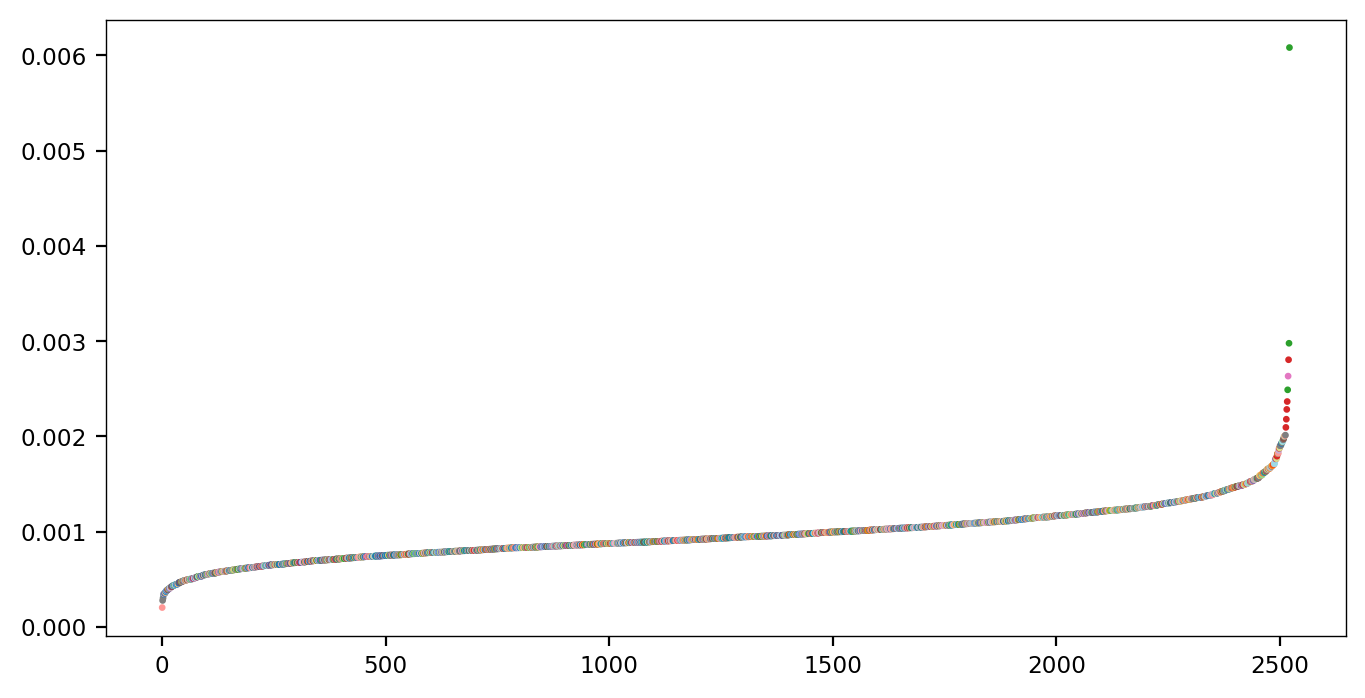

In [39]:
# quick check — do the chromosomes blend? yes.
fig, ax = plt.subplots()
pis = pi_from_pairwise_summaries(bins_1Mbp.Y())
idx = np.argsort(pis)
ax.scatter(np.arange(len(pis)), pis[idx], c=bins_1Mbp.chrom_ints()[idx], s=2, 
           cmap=mpl.colormaps.get_cmap('tab20'))

### The Distribution of Genome-Wide Pairwise Diversities

Let's fit a normal to the filtered data.

In [40]:
pis_trimmed = pi_from_pairwise_summaries(bins_1Mbp_trimmed.Y(filter_masked=True))
loc, scale = stats.norm.fit(pis_trimmed)

In [41]:
loc, scale

(0.0009612387966825049, 0.000261866724507944)

Make a supplementary figure:

In [42]:
fig_sizes[('two', 'two')]*0.8

array([5.98424, 2.99216])

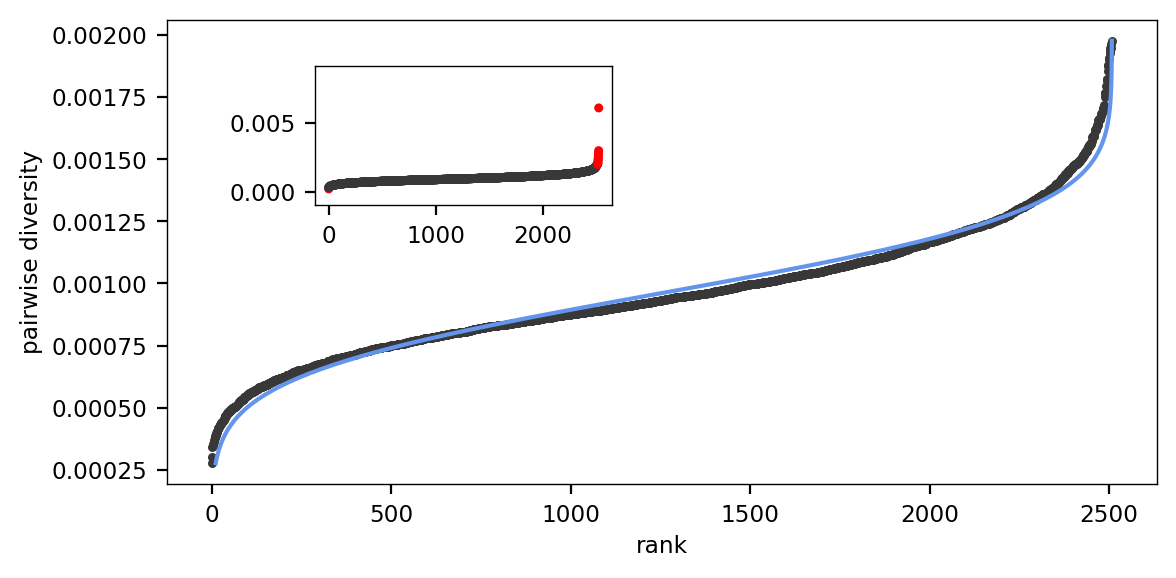

In [43]:
bins_1Mbp_trimmed.clear_masks()
bins_1Mbp_trimmed.mask_outliers((0, 0.995))

fig, ax = plt.subplots(figsize=fig_sizes[('two', 'two')]*0.8)
pis = pi_from_pairwise_summaries(bins_1Mbp.Y())
pis_trimmed = pi_from_pairwise_summaries(bins_1Mbp_trimmed.Y(filter_masked=False))

masked = bins_1Mbp_trimmed.mask_array

#col = [{True: '0.22', False: 'c'}[p in pis_trimmed] for p in pis]
#ax.scatter(np.arange(len(pis)), np.sort(pis), s=2)

idx = np.argsort(pis_trimmed)

inset_ax = ax.inset_axes([0.15, 0.6, 0.3, 0.3])

inset_ax.scatter(np.arange(len(pis_trimmed)), pis_trimmed[idx], c=masked[idx], s=5,
           cmap=mpl.colors.LinearSegmentedColormap.from_list('outliers', ['red', '0.22']))

inset_ax.spines['right'].set_visible(True)
inset_ax.spines['top'].set_visible(True)
inset_ax.set_ylim(-0.001, np.nanmax(pis_trimmed[idx])*1.5)

pis_trimmed = pi_from_pairwise_summaries(bins_1Mbp_trimmed.Y(filter_masked=True))

z = np.linspace(np.nanmin(pis_trimmed), np.nanmax(pis_trimmed), 100)
ax.plot(stats.norm.cdf(z, loc, scale)*len(pis_trimmed), z, c='cornflowerblue')
ax.scatter(np.arange(len(pis_trimmed)), np.sort(pis_trimmed), s=5, c='0.22')

ax.set_ylabel('pairwise diversity')
ax.set_xlabel('rank')
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, 'supplementary', 'diversity_trimming_dist.pdf'))

This shows that it's nearly normal, but with fatter tails.

### YRI Diversity Bootstrap

Now, let us use the megabase windows to bootstrap YRI pairwise diversity.

Note that it's *very* important to note what the bootstrap is doing here. We are sampling over genomic blocks, which treats the observed genome as a sample from an imaginary population of genomic blocks, rather than something fixed we're sampling chromosomes from. Thus there are two sources of uncertainty: 

 - **Chromosomes sampled from individuals**: this is the "true" sample. 
 - **Genomic regions sampled from a population** this is what we use for bootstrapping.
 
Let us think about the relative sizes of these processes. Imagine a neutral coalescent model along a chromosome: we know the the individual sampling variance is << evolutionary sampling variance. Block bootstrapping is sampling over the distribution of tree collections in a window, which means its randomness is approximating the true genome coalescent distribution.



In [44]:
# 28 is the max number of megabase blocks, set by the smallest chromosome
block_sizes = np.array([1, 5, 10, 20, 25, 28])
biases_1Mbp = []
for nblock in block_sizes:
    biases_1Mbp.append(bins_1Mbp_trimmed.estimate_pi_bias(B=500, nblocks=nblock))
    

In [45]:
biases_100kbp = []
block_sizes_100kbp = np.array([1, 10, 50, 100, 300, 400])
for nblock in block_sizes_100kbp:
    biases_100kbp.append(bins_100kbp.estimate_pi_bias(B=500, nblocks=nblock))
    

Let's check that our bootstrap isn't sensitive to window size, which it shouldn't be.


Text(0.5, 0, 'block size (Megabases)')

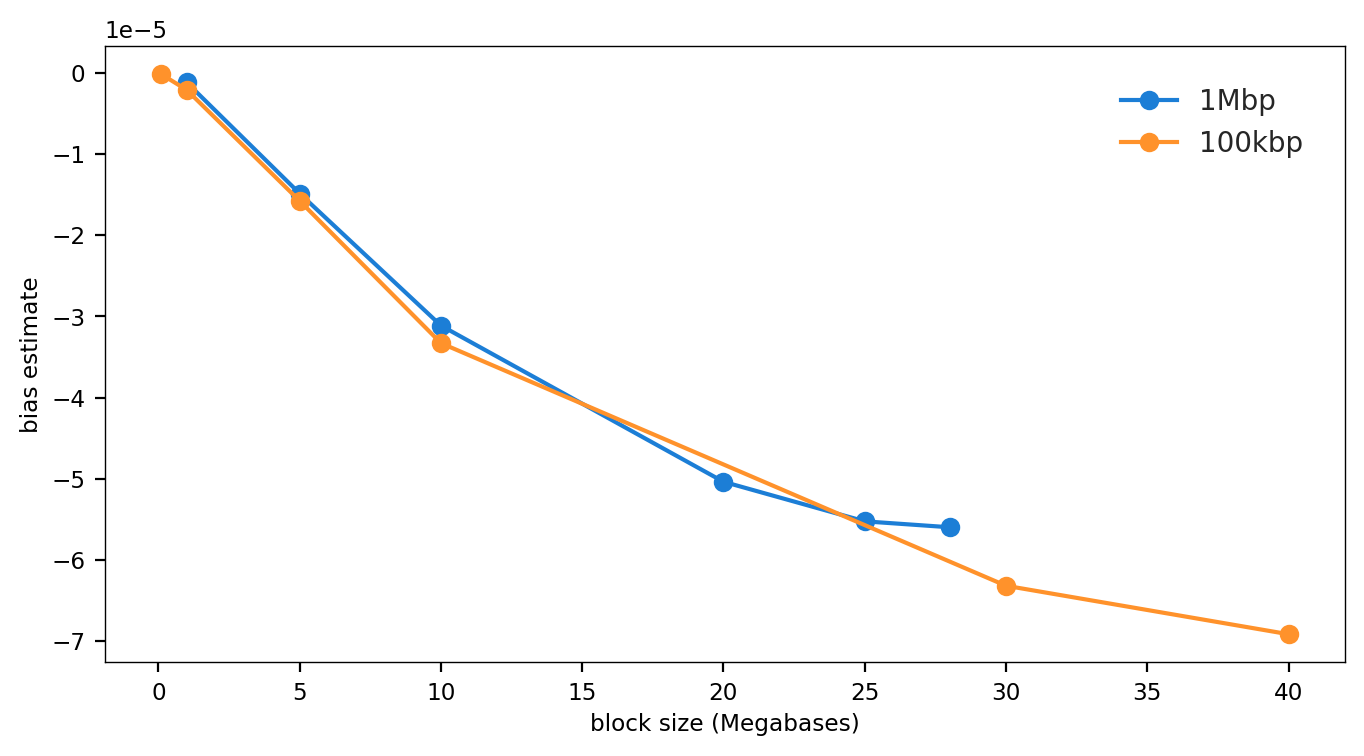

In [46]:
fig, ax = plt.subplots()
ax.plot(block_sizes*bins_1Mbp_trimmed.width / 1e6, biases_1Mbp, '-o', label='1Mbp')
ax.plot(block_sizes_100kbp*bins_100kbp.width / 1e6, biases_100kbp, '-o', label='100kbp')
ax.legend()
ax.set_ylabel("bias estimate")
ax.set_xlabel(f"block size (Megabases)")

It's invariant to window size as expected, but the bias estimate is highly dependent on the total block size. I believe the most conservative thing to do is use the largest observed bias, which amounts to nearly resampling whole chromosomes. 

This may be expected just because it takes longer "blocks" than chromosomes to get a plateau in the bias estimate, effectively meaning that regions are not independent of one another even if they are on different chromsomes. 

In [47]:
# approximate number of blocks possible
bs_bias = bins_100kbp.estimate_pi_bias(B=500, nblocks=460)
bs_bias

-6.957175298280983e-05

In [48]:
# what's the relative error due to bias? this is in percent
rel_error(est=gw_yri, truth=gw_yri - bs_bias)

6.671714449534432

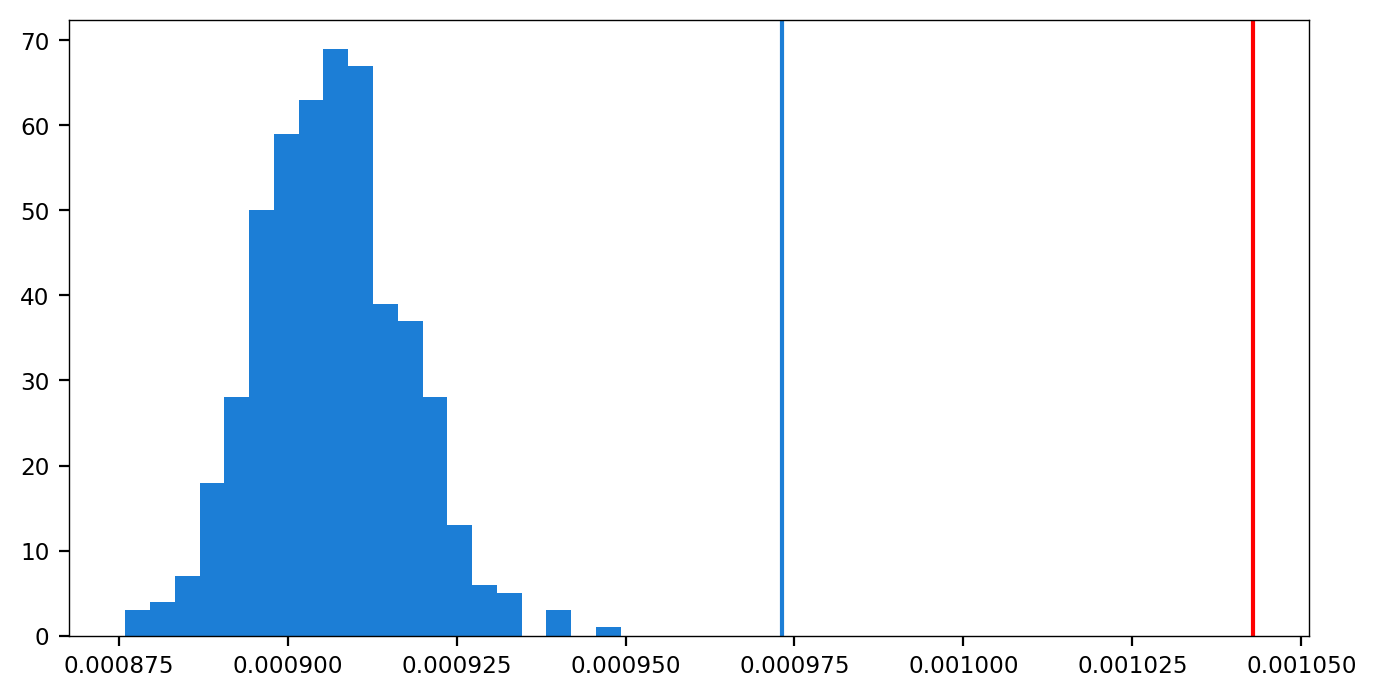

In [49]:
_ = plt.hist(bins_1Mbp_trimmed.bootstrap_pi(500, 28)[0], 20)
plt.axvline(gw_yri)
plt.axvline(gw_yri - bs_bias, c='r')

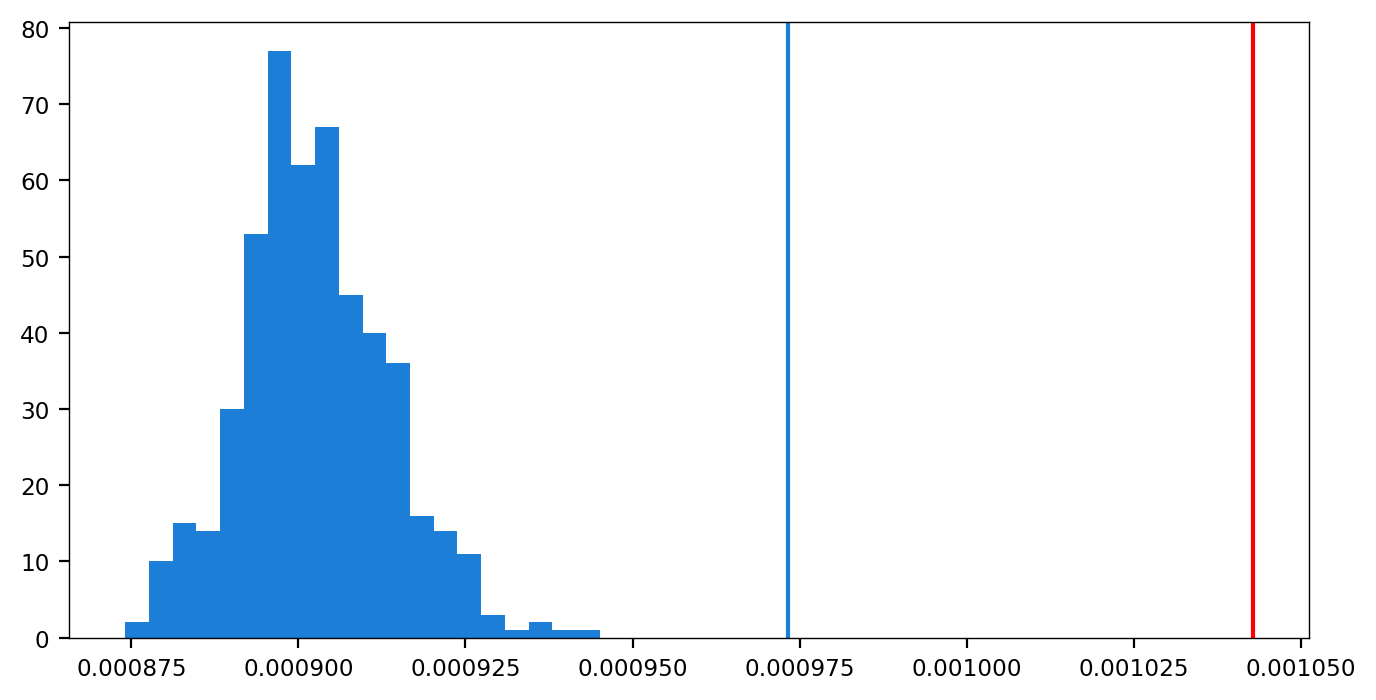

In [50]:
_ = plt.hist(bins_100kbp.bootstrap_pi(500, 460)[0], 20)
plt.axvline(gw_yri)
plt.axvline(gw_yri - bs_bias, c='r')

In [51]:
bins_100kbp.gwpi(), bins_1Mbp.gwpi()

(0.0009732149776103245, 0.0009732149776103245)

In [52]:
bins_100kbp.bias_corrected_gwpi(500, 28)

0.000981524514812487

In [53]:
gw_yri

0.0009732149776103245

So clearly there is bias according to the block-bootstrap procedure. This isn't unexpected, as pairwise diversity is a ratio estimator.

## Chromosome 1 Pairwise Diversity Compared to Other Studies.

Here we focus on megabase-scale variation, as this is the scale to see BGS effects (and it allows us to compare our diversity levels to those of Murphy et al. (2022)).

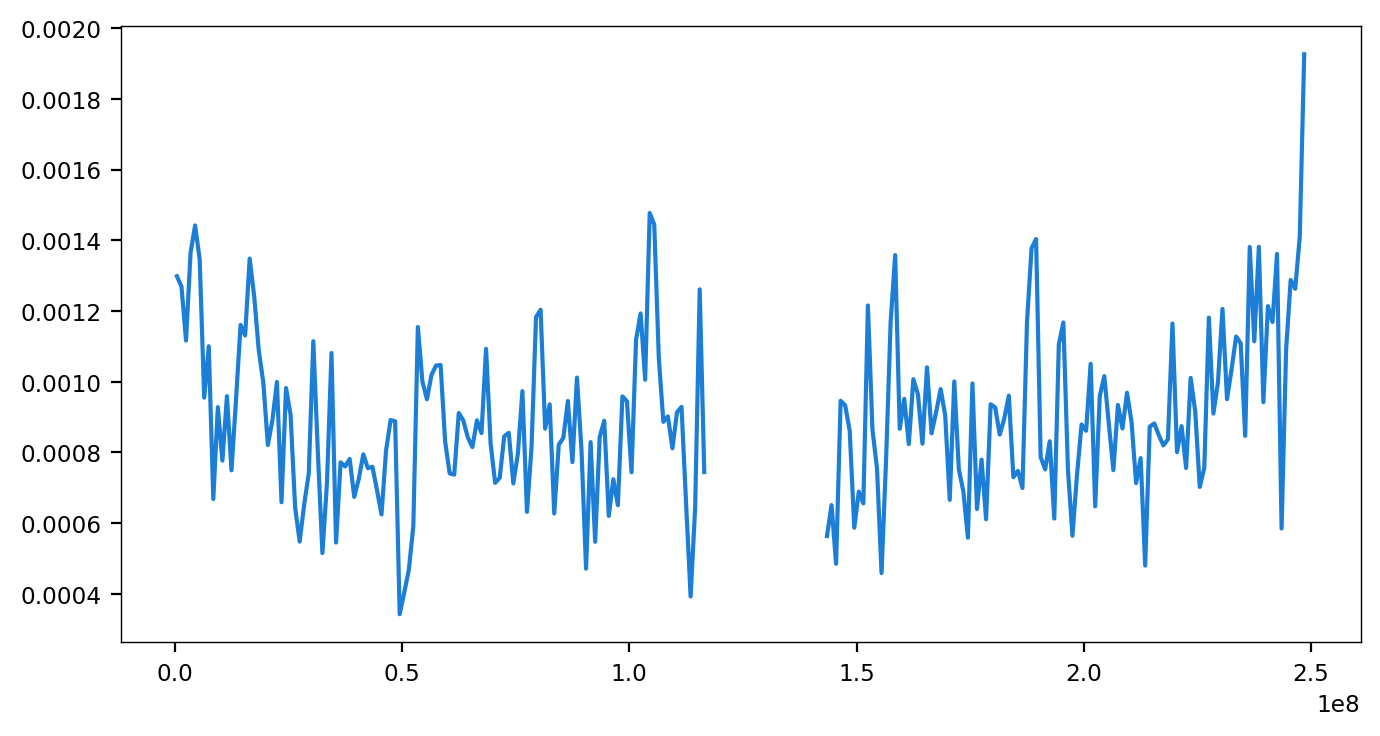

In [54]:
plt.plot(*bins_1Mbp_trimmed.pi_pairs('chr1'))

This file is from Murillo Rodrigues forthcoming paper on diversity and divergence across the great apes — it uses data aligned to hg18. Note that I have *not* lifted this over to hg38, so some discrepencies are due to different genomic coordinates.

In [55]:
dalt = pd.read_csv('../data/all_pidxy_win-size_1000000_merged-mask_True_state_all_curr_all.tsv', sep='\t')
dalt['midpoint'] = (dalt.start + dalt.end)/2
dalt_pi = dalt.loc[(dalt.stat == 'pi') & (dalt.spp1 == 'homo') & (dalt.spp2 == 'homo')]
dalt_dxy = dalt.loc[(dalt.stat == 'dxy') & (dalt.spp2 == 'homo') &  
                    ((dalt.spp1 == 'weastern_chimp') | (dalt.spp1 == 'eastern_chimp'))]

In [56]:
dalt_dxy.head()

value stat           spp1  spp2   chr    start      end  \
15624       NaN  dxy  eastern_chimp  homo  chr1        1  1000000   
15625  0.012834  dxy  eastern_chimp  homo  chr1  1000001  2000000   
15626  0.014483  dxy  eastern_chimp  homo  chr1  2000001  3000000   
15627  0.015186  dxy  eastern_chimp  homo  chr1  3000001  4000000   
15628  0.015014  dxy  eastern_chimp  homo  chr1  4000001  5000000   

       n_acc_bases  n_snps   midpoint  
15624            0       0   500000.5  
15625       283857    7487  1500000.5  
15626       455783   13809  2500000.5  
15627       570312   17927  3500000.5  
15628       794579   24642  4500000.5

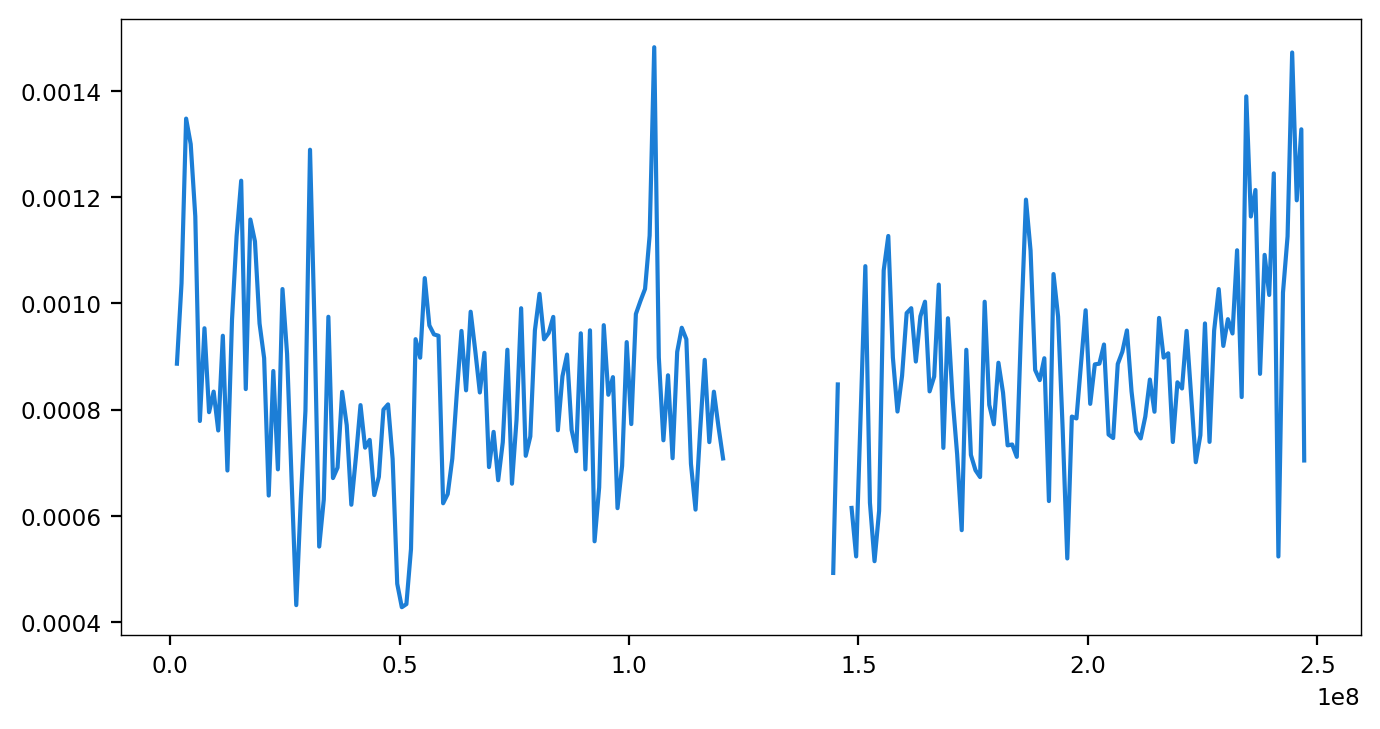

In [57]:
ddd = dalt_pi.loc[dalt_pi.chr == 'chr1']
plt.plot(ddd.midpoint, ddd.value)

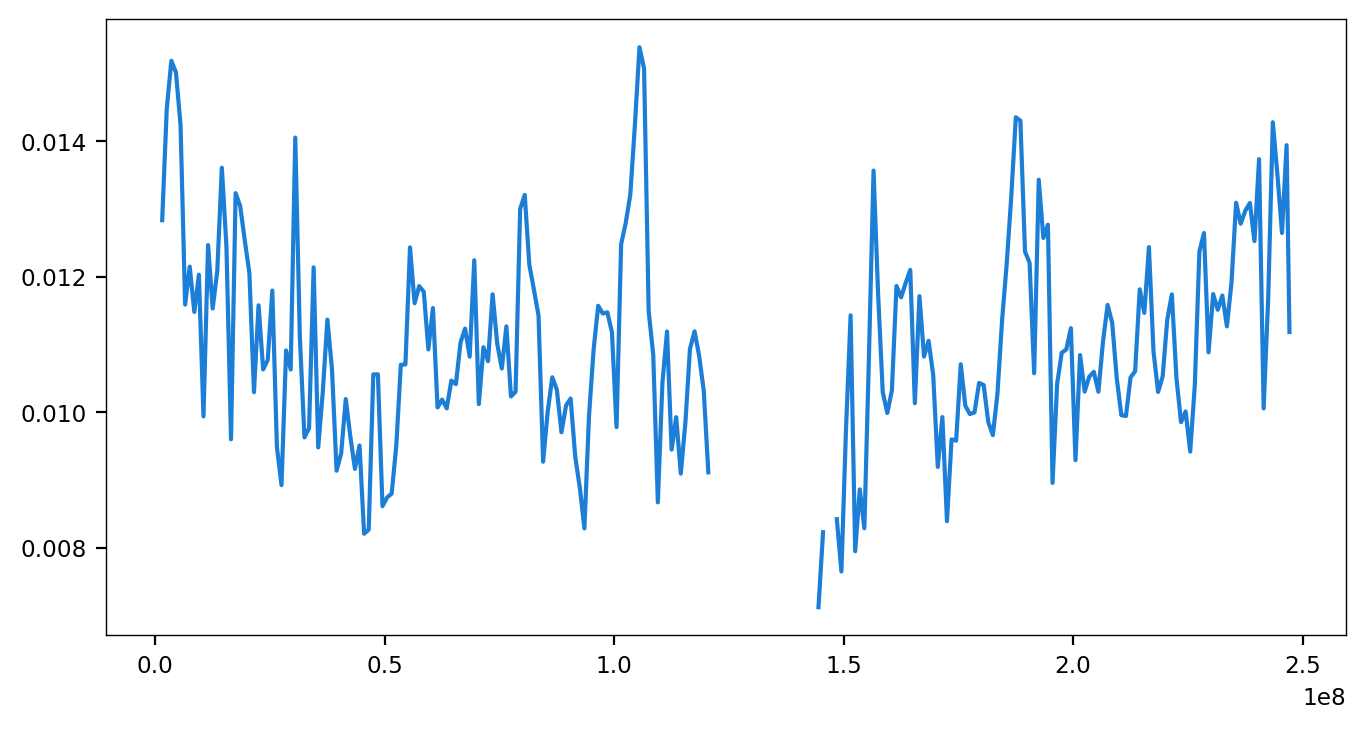

In [58]:
ddd = dalt_dxy.loc[dalt_dxy.chr == 'chr1']
plt.plot(ddd.midpoint, ddd.value)

(array([1.000e+02, 2.065e+03, 4.880e+02, 2.100e+01, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.00054257, 0.00108514, 0.00162772, 0.00217029,
        0.00271286, 0.00325543, 0.00379801, 0.00434058, 0.00488315,
        0.00542572]),
 <BarContainer object of 10 artists>)

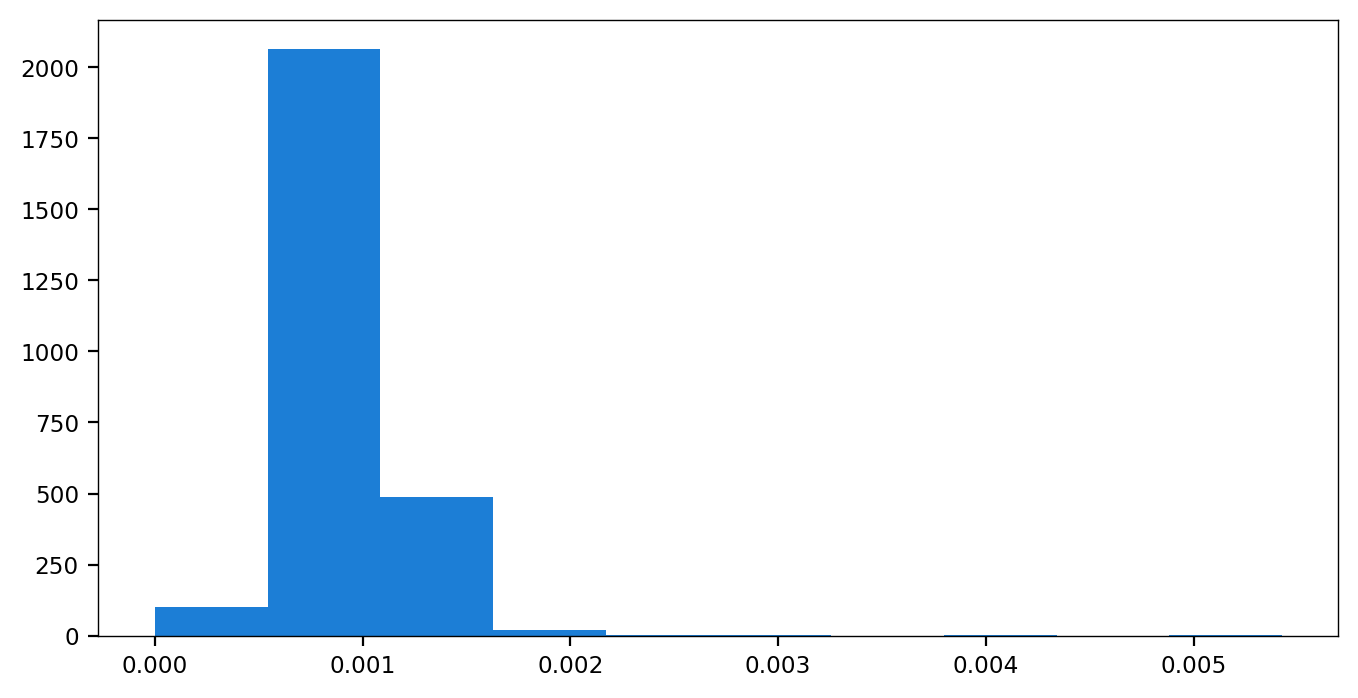

In [60]:
plt.hist(dalt_pi['value'])

This file is from a figure in Murphy et al. (2022) — I digitized this using the web digitizer tool for comparison with our values. This also uses hg18 data so there is some discrepency due to coordinate shifts.

In [61]:
md = pd.read_csv('../data/murphy_digitized.csv', names=('pos', 'pi'))

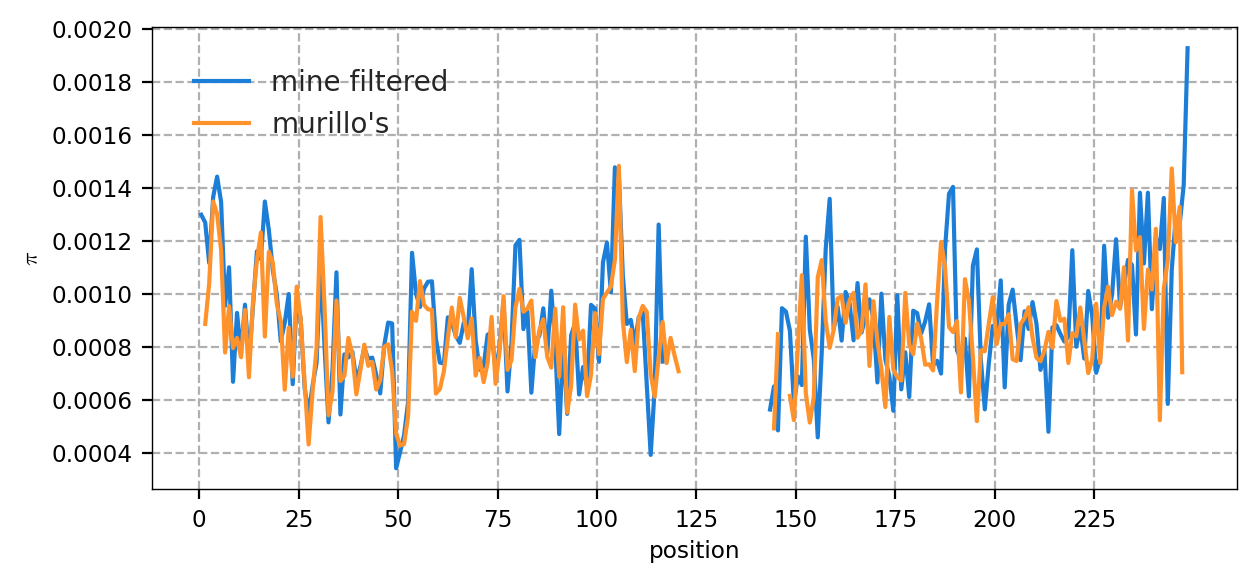

In [62]:
fig, ax = plt.subplots(figsize=(7, 3))

def to_mb(x):
    return np.array(x) / 1e6

x, y = bins_1Mbp_trimmed.pi_pairs('chr1')
ax.plot(to_mb(x), y, label='mine filtered')

#x, y = pi_alt['chr1'].pairs
#ax.plot(to_mb(x), y, label='mine unfiltered')

dalt_pi_chr1 = dalt_pi.loc[dalt_pi.chr == 'chr1']
ax.plot(to_mb(dalt_pi_chr1.midpoint), dalt_pi_chr1.value, label="murillo's")
grid = np.arange(0, 250, 25)
ax.set_xticks(grid)
ax.set_xlabel('position')
ax.set_ylabel('$\pi$')
ax.legend()
ax.grid(linestyle='dashed')

The overall patterns are quite close. Note that the offset after the centromere is from the genome reference differences (hg18 vs hg38).

Let's take the $\frac{\pi}{\bar{pi}}$ ratio to put these on the same scale:

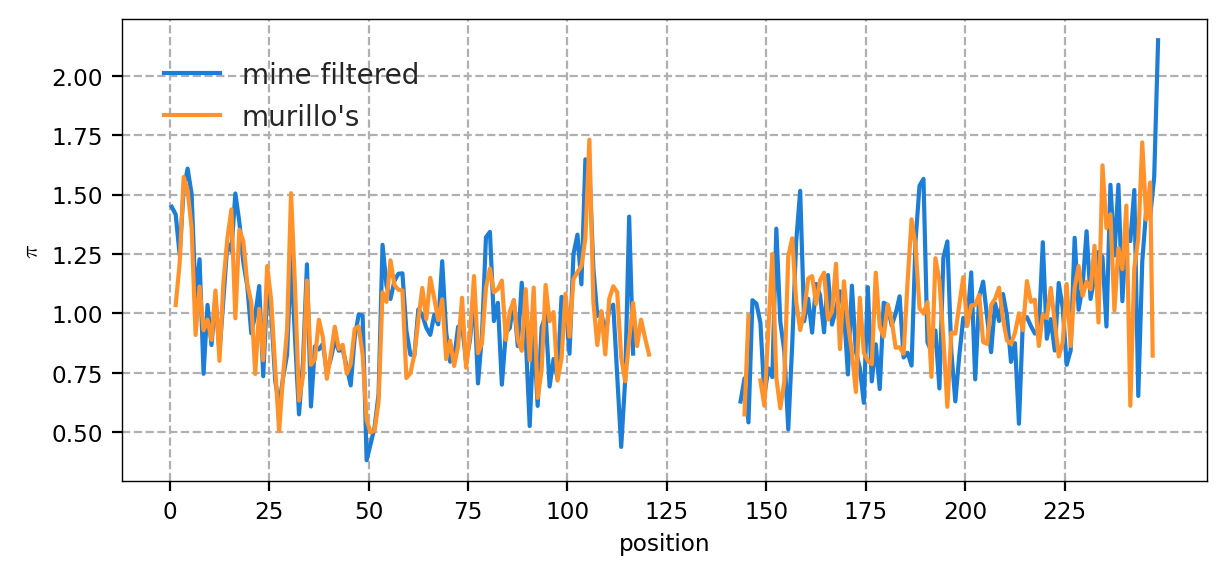

In [63]:
fig, ax = plt.subplots(figsize=(7, 3))

x, y = bins_1Mbp_trimmed.pi_pairs('chr1', ratio=True)
ax.plot(to_mb(x), y, label='mine filtered')

#x, y = pi_alt['chr1'].pairs
#ax.plot(to_mb(x), y, label='mine unfiltered')

dalt_pi_chr1 = dalt_pi.loc[dalt_pi.chr == 'chr1']
ax.plot(to_mb(dalt_pi_chr1.midpoint), mean_ratio(dalt_pi_chr1.value), label="murillo's")
grid = np.arange(0, 250, 25)
ax.set_xticks(grid)
ax.set_xlabel('position')
ax.set_ylabel('$\pi$')
ax.legend()
ax.grid(linestyle='dashed')

Again, some of the disparity is different genome versions, especially after the centromere.

## Dependencies

Bins are spatially correlated, creating dependencies in the data. We assess and model these here.

Since we reduce data at the megabase bin level, we want to look at the level of autocorrelation/autocovariance at differing levels of bins away using a covariogram. One quick way to do this is

$$g(l) = \mathrm{cov}(i, i+l)$$

where $l$ is the bin index lag. Since recombination rates vary, we also look put this on the natural scale of map position.
 
$$g_m(m) = \mathrm{E}(\mathrm{cov}(m(x), m(x+l)))$$


### Model

We can think about our model as,

$$
\pi(z) = \underbrace{\pi_0 B(z | \theta)}_\text{mean field} + \epsilon(z)
$$

Our error term $\epsilon(z)$ is possible spatially autocorrelated. There exists some empirical covariogram function $\hat{C}(h) = \mathrm{cov}(Y(z), Y(z+h))$ we can estimate from the data directly. However, we are uncertain about both (1) the spatial scale of $\hat{C}(h)$ and (2) whether the dependency is caused by autocorrelation in the mean field $B(z)$ or the error term $\epsilon(z)$. Here, $\epsilon(z)$ includes sampling processes and random genetic drift around the mean field.

We can determine (1) directly from the empirical data. For (2), it is trickier — the clearest way is to generate Monte Carlo realizations of $\pi(z)$ under the neutral process and the sampling process and measure the spatial scale of $C(h)$ (we do this at the very end).


Since mutation is a Poisson point process along the chromosome, we must define the scale at which we measure it.

The bigger question is whether we model the covariance structure, regardless of its source, when trying to estimate $\theta$ from $\pi(z)$. Fundamentally, a composite likelihood assumes independence between binned measurements of $\pi(z)$ — in the case of learning $\theta)$, we want to *discount* nearby observations by some amount because they're not telling us independent bits of information about $\theta$, but rather looking at the same section of $B(z | \theta)$. Thus, we want to control for the total autocovariance. Note that this parallels some debate about what we are controlling for in phylogenetic comparative methods, as well as causal literature. However in this latter case, note that we're not really "controlling" for things in the same way, as we're modeling covariance, not fixed or random effects.

Another way to think about this is: if we generate a random process under $B(z | \theta)$, do we get better inferences if we control for covariance between observations?

One thing is that the mean field itself is *random*, and in this sense, it does make sense to downweight neighboring observations.

Text(0.5, 1.0, 'cov(i, i-1) = nan, var(i-1, i-1) = nan, var(i, i) = nan')

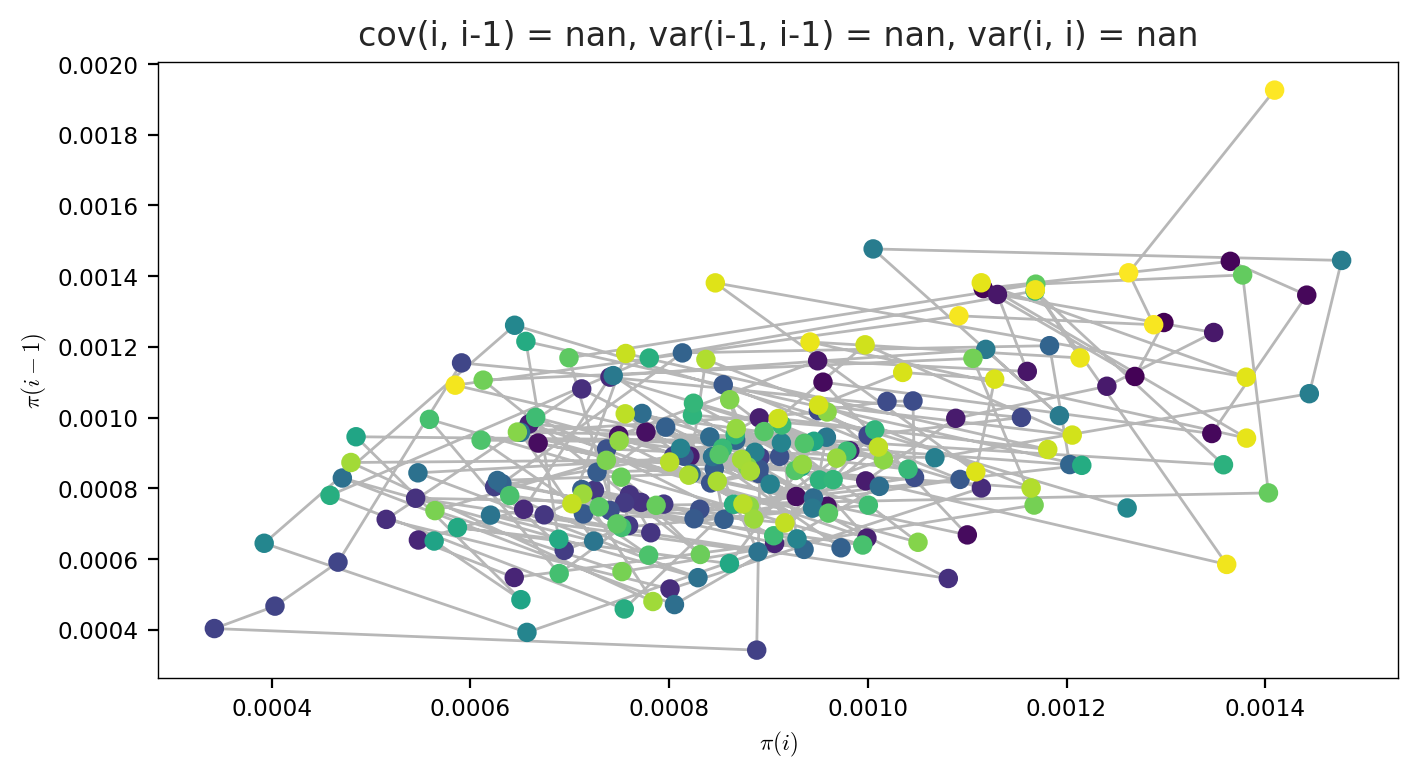

In [64]:
pi = pi_from_pairwise_summaries(bins_1Mbp.data()['chr1'])

lag = 1
xpi = pi
p1, p2 = xpi[:-(lag)], xpi[(lag):]

plt.plot(p1, p2, linewidth=1, c='0.44', alpha=0.5)
plt.scatter(p1, p2, c=np.arange(len(xpi[(lag):])), zorder=3)
plt.xlabel('$\pi(i)$')
plt.ylabel('$\pi(i-1)$')
#plt.scatter(pi[:-1], pi[1:], c=pi[1:], zorder=3)
cov = np.cov(p1, p2)
plt.title(f"cov(i, i-1) = {cov[0, 1]:.4}, var(i-1, i-1) = {cov[0, 0]:.4}, var(i, i) = {cov[0, 0]:.4}")

Is this first-order covariance significant? Let's do a permutation test:

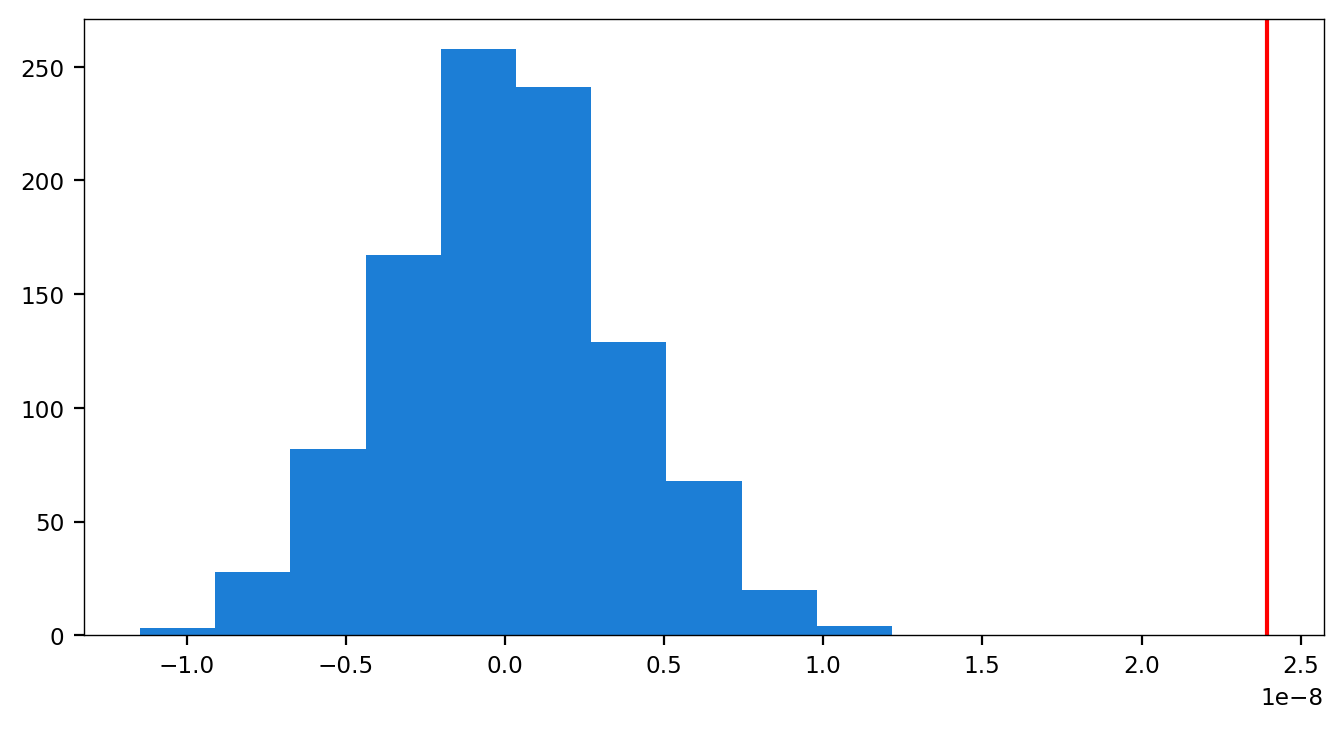

In [65]:
nperms = 1000
null = np.zeros(nperms)
keep = ~(np.isnan(p1) | np.isnan(p2))
for i in range(nperms):
    null[i] = np.cov(p1[keep], np.random.permutation(p2[keep]))[0, 1]

plt.hist(null)
plt.axvline(np.cov(p1[keep], p2[keep])[0, 1], c='r')

## Binned Variograms and Covariograms

In [66]:
R, M, N = bins_1Mbp.binned_funcgram(g.recmap)

/home/vsb/projects/bprime/bgspy/data.py:829: RuntimeWarning: Mean of empty slice
  func=lambda x, y: np.nanmean((x-y)**2)):


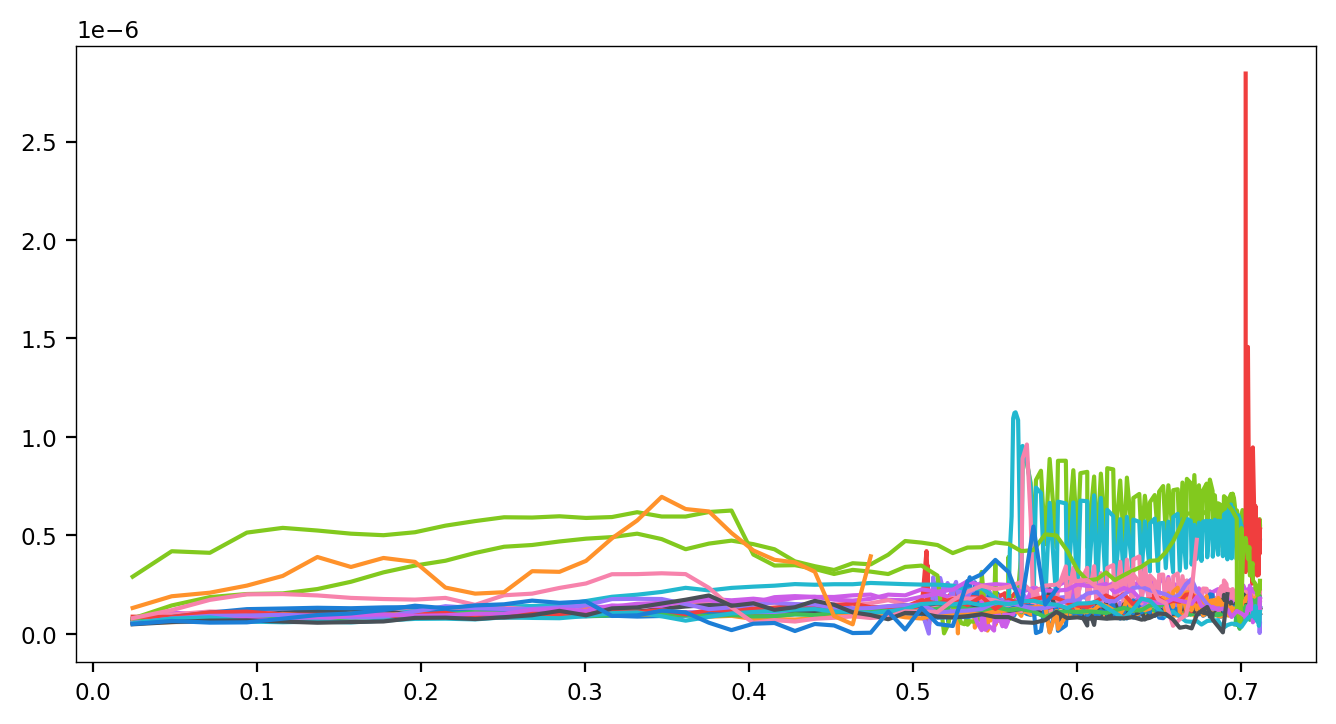

In [67]:
_ = plt.plot(R, M)

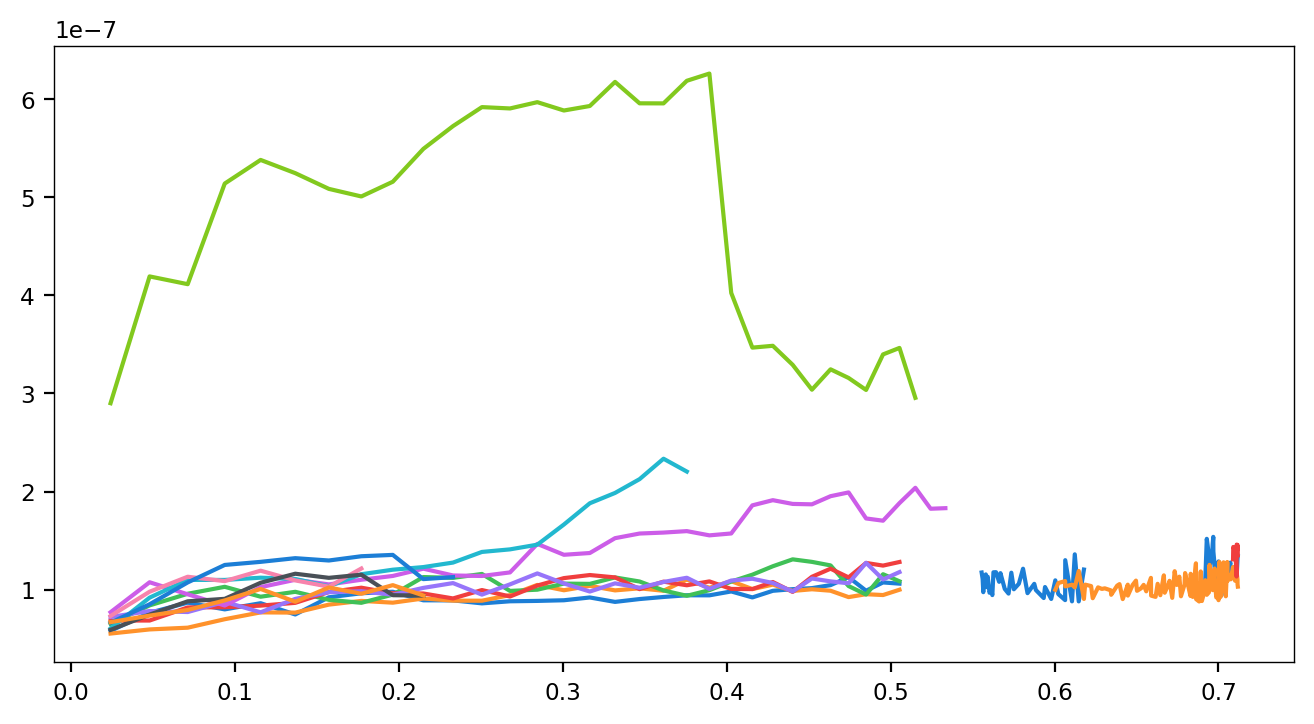

In [68]:
min_n = 100
_ = plt.plot(np.ma.array(R, mask = N < min_n),
             np.ma.array(M, mask = N < min_n))

(0.0, 0.55)

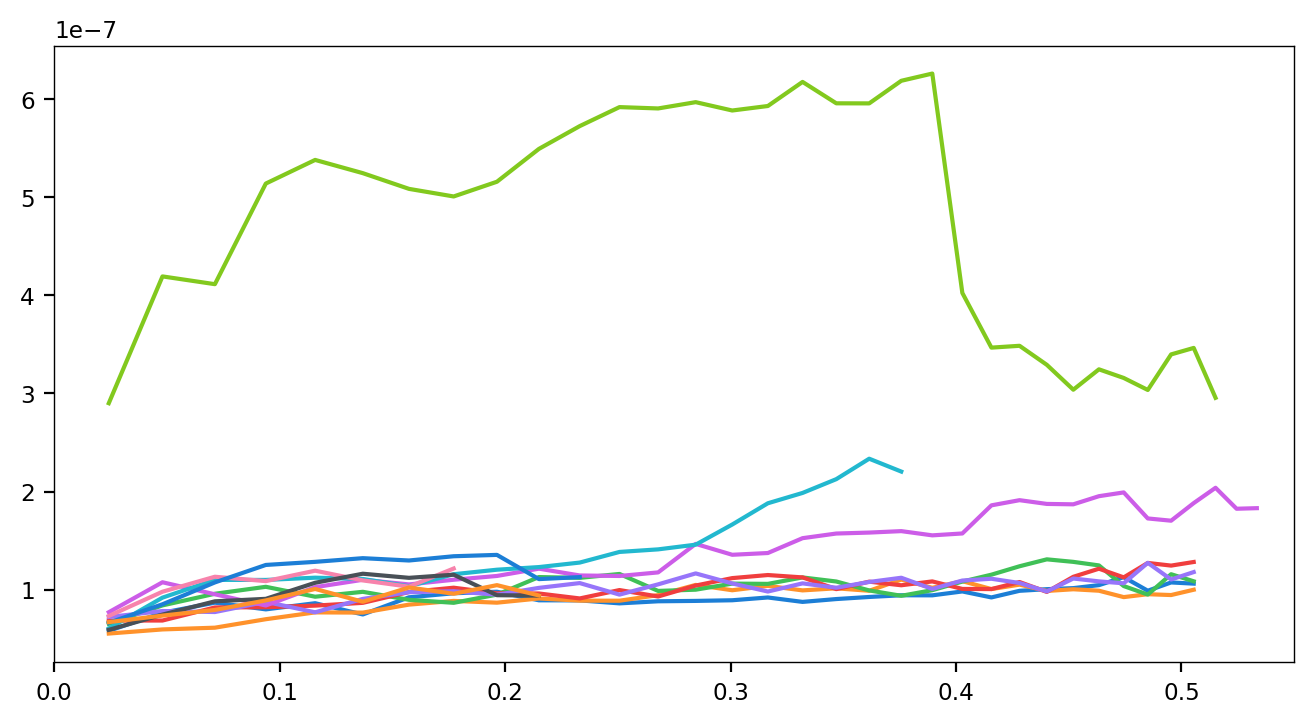

In [69]:
_ = plt.plot(np.ma.array(R, mask = N < min_n),
             np.ma.array(M, mask = N < min_n))
plt.xlim(0, 0.55)

### Binned Covariogram

In [70]:
def covar(x, y):
    keep = ~np.isnan(x) & ~np.isnan(y)
    if keep.sum() <= 1:
        return np.nan
    xi, yi = x[keep], y[keep]
    return np.cov(xi, yi)[0, 1]

def corr2(x, y):
    keep = ~np.isnan(x) & ~np.isnan(y)
    if keep.sum() <= 1:
        return np.nan
    xi, yi = x[keep], y[keep]
    return np.corrcoef(xi, yi)[0, 1]

In [71]:
R_cor, M_cor, N_cor = bins_1Mbp.binned_funcgram(g.recmap, func=corr2)

In [72]:
R_cov, M_cov, N_cov = bins_1Mbp.binned_funcgram(g.recmap, func=covar)

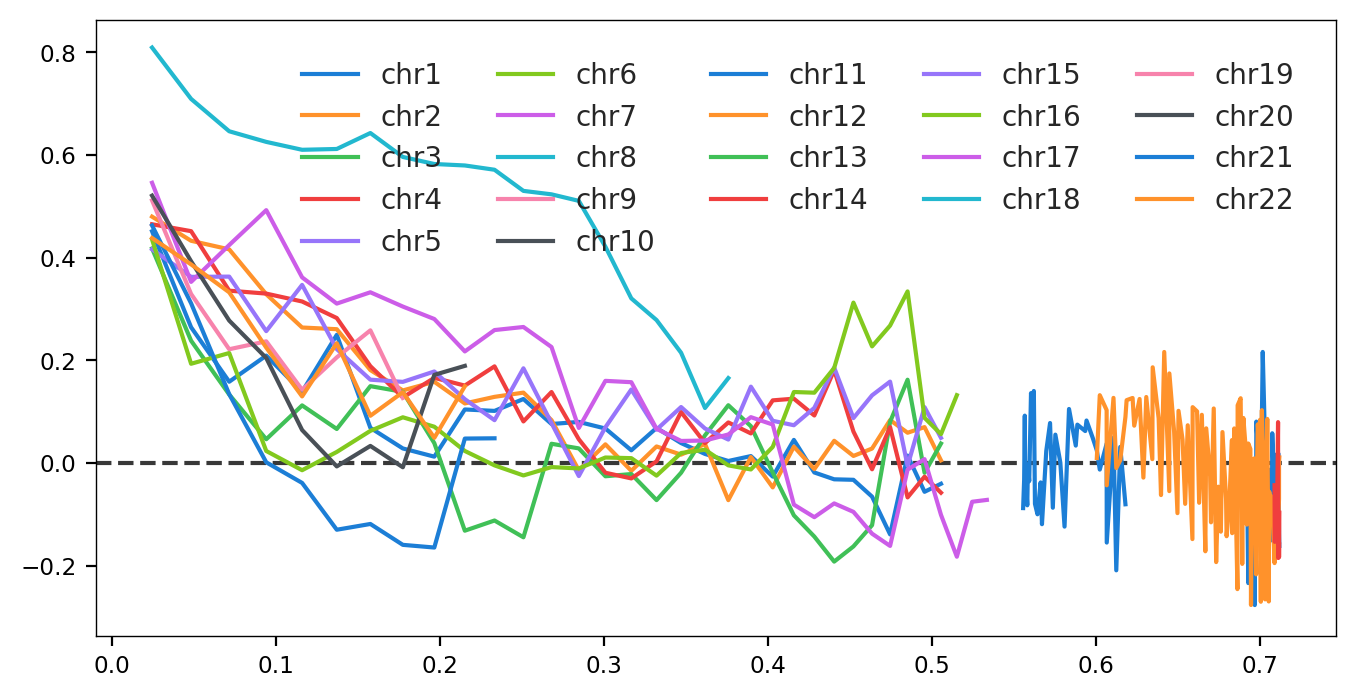

In [73]:
for i, chrom in enumerate(bins_1Mbp.seqlens):
    _ = plt.plot(np.ma.array(R_cor, mask = N_cor < min_n)[:, i],
                 np.ma.array(M_cor, mask = N_cor < min_n)[:, i], label=chrom)

plt.axhline(0, linestyle='dashed', c='0.22', zorder=-1)
plt.legend(ncol=5)

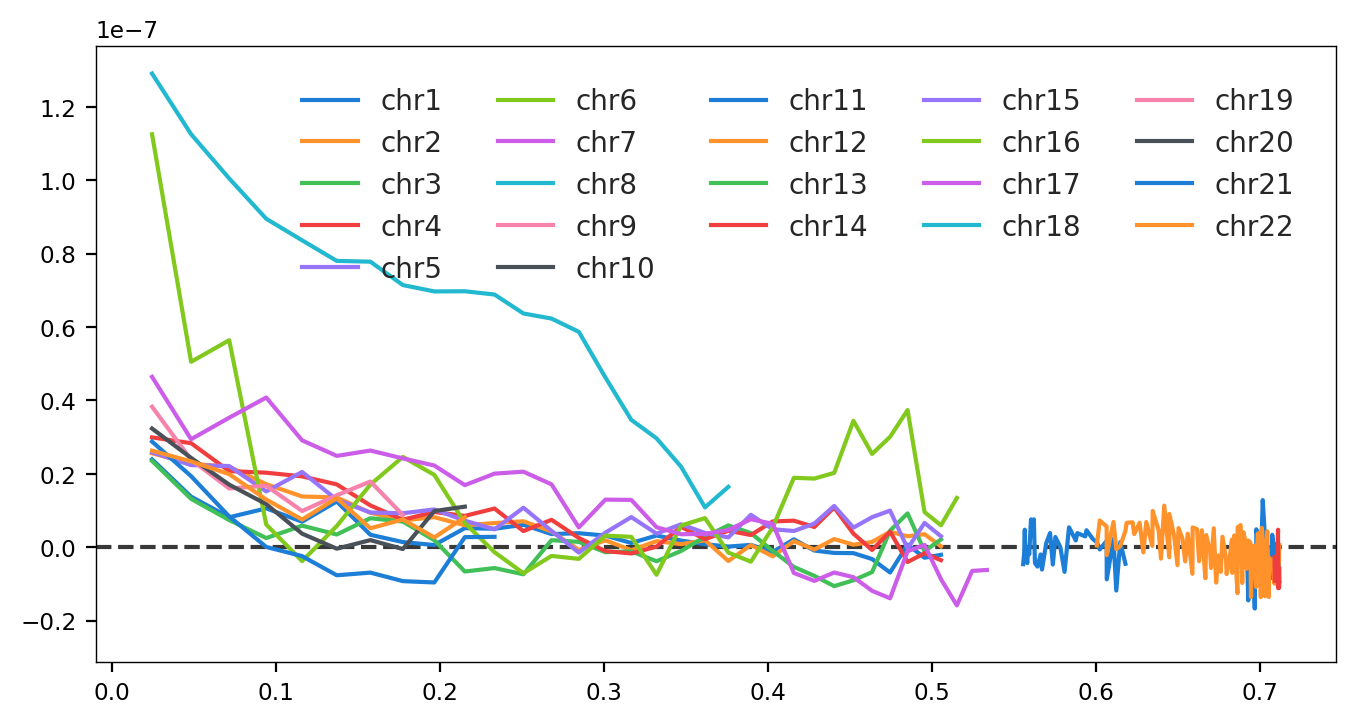

In [74]:
for i, chrom in enumerate(bins_1Mbp.seqlens):
    _ = plt.plot(np.ma.array(R_cov, mask = N_cov < min_n)[:, i],
                 np.ma.array(M_cov, mask = N_cov < min_n)[:, i], label=chrom)

plt.axhline(0, linestyle='dashed', c='0.22', zorder=-1)
plt.legend(ncol=5)

In [75]:
# exclude some outlier chromosomes
(M_cov > 1e-7).sum(axis=0)

array([0, 0, 0, 0, 0, 2, 0, 3, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2])

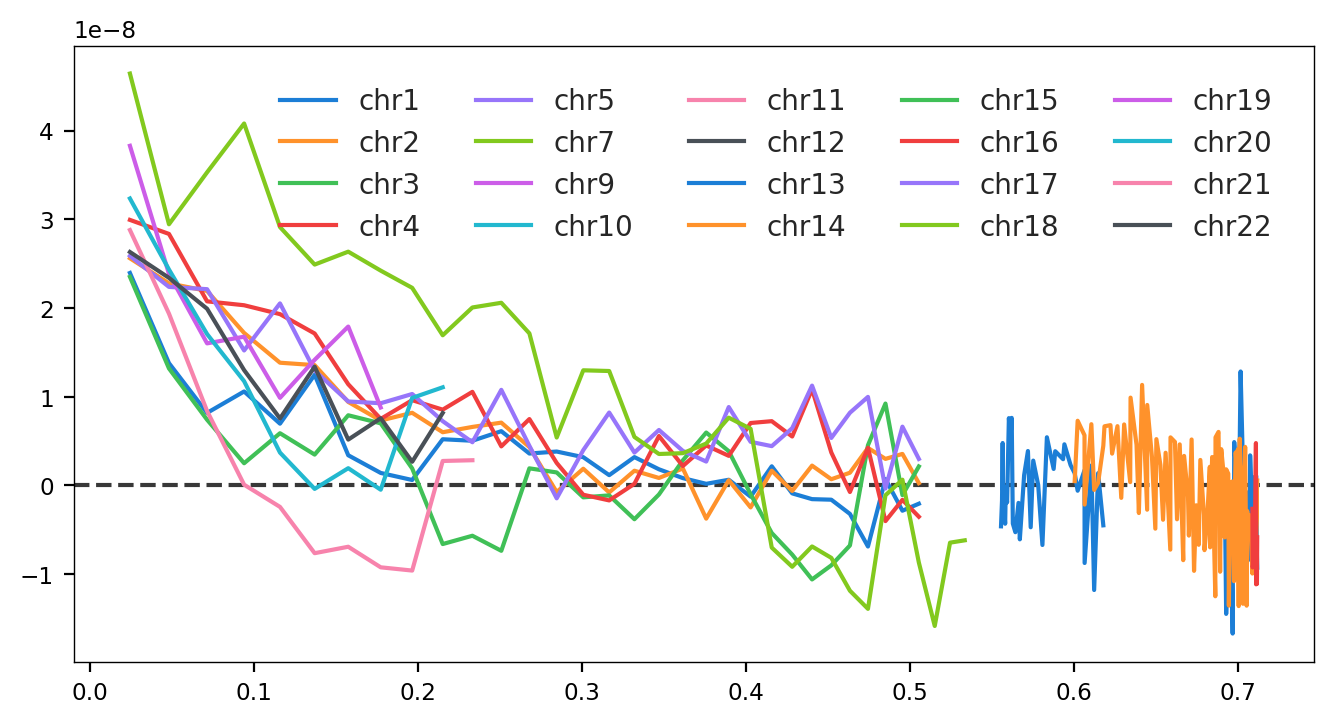

In [76]:
exclude = ['chr6', 'chr8']
for i, chrom in enumerate(bins_1Mbp.seqlens):
    if chrom in exclude:
        continue
    _ = plt.plot(np.ma.array(R_cov, mask = N_cov < min_n)[:, i],
                 np.ma.array(M_cov, mask = N_cov < min_n)[:, i], label=chrom)

plt.axhline(0, linestyle='dashed', c='0.22', zorder=-1)
plt.legend(ncol=5)

Now let's bootstrap the diversity covariogram at the chromosome level:

Text(0, 0.5, 'covariance')

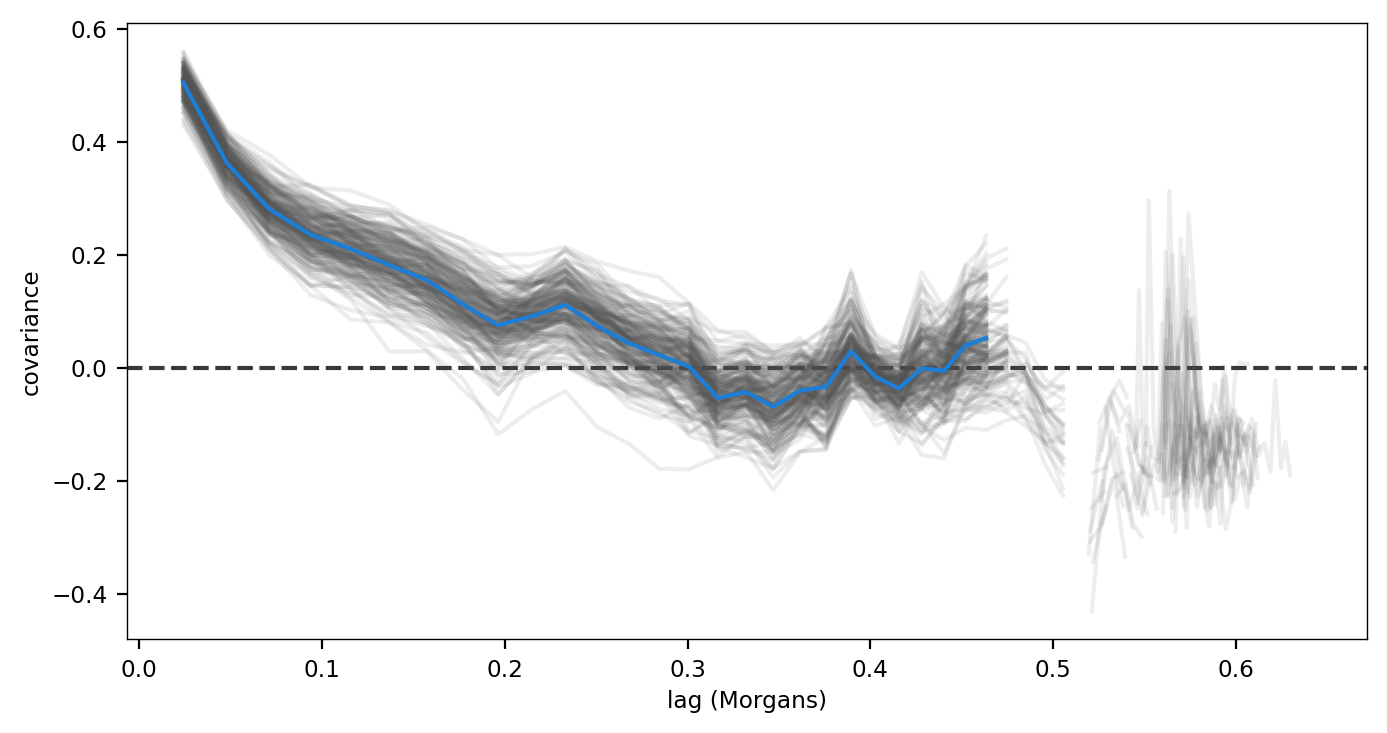

In [77]:
# with pi


bs = []
rs = []
stat = np.mean
for i in range(200):
    idx = np.random.randint(0, M.shape[1], M.shape[1])
    bs.append(stat(M_cor[:, idx], axis=1))
    rs.append(stat(R_cor[:, idx], axis=1))
    
_ = plt.plot(np.stack(rs).T, np.stack(bs).T, c='0.33', alpha=0.1)
plt.axhline(0, linestyle='dashed', c='0.22', zorder=-10)
plt.plot(stat(R_cor, axis=1), stat(M_cor, axis=1))
plt.xlabel('lag (Morgans)')
plt.ylabel('covariance')

/home/vsb/miniconda3/envs/bprime/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


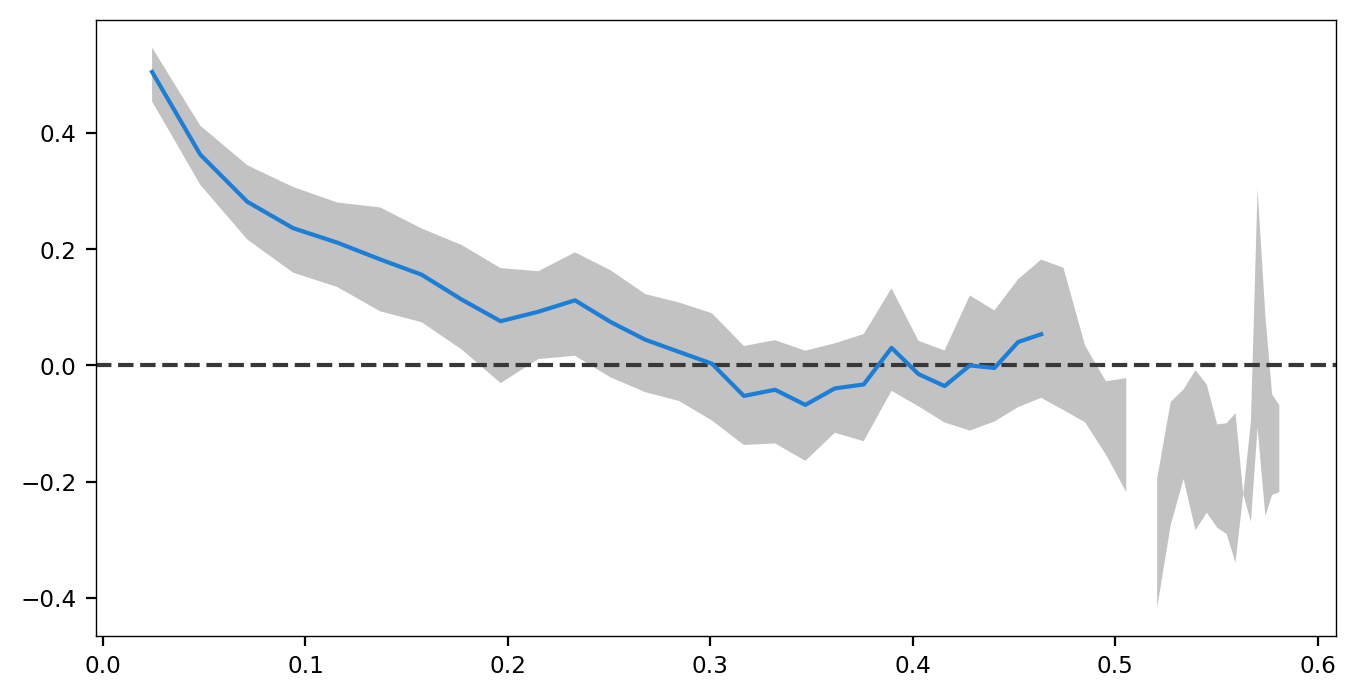

In [81]:
plt.plot(stat(R_cor, axis=1), stat(M_cor, axis=1))
plt.fill_between(stat(R_cor, axis=1), *percentile_ci(np.stack(bs)), color='0.22', alpha=0.3, linewidth=0)
plt.axhline(0, linestyle='dashed', c='0.22', zorder=-10)


## Simulated Kernels

In [82]:
msp_data = np.load('../msprime_sims/YRI_178_1Mbp.npz')
chr1_bins, yri_pi_sims = msp_data['bins'], msp_data['pi']
chr1_mps = 0.5*(chr1_bins[1:] + chr1_bins[:-1])

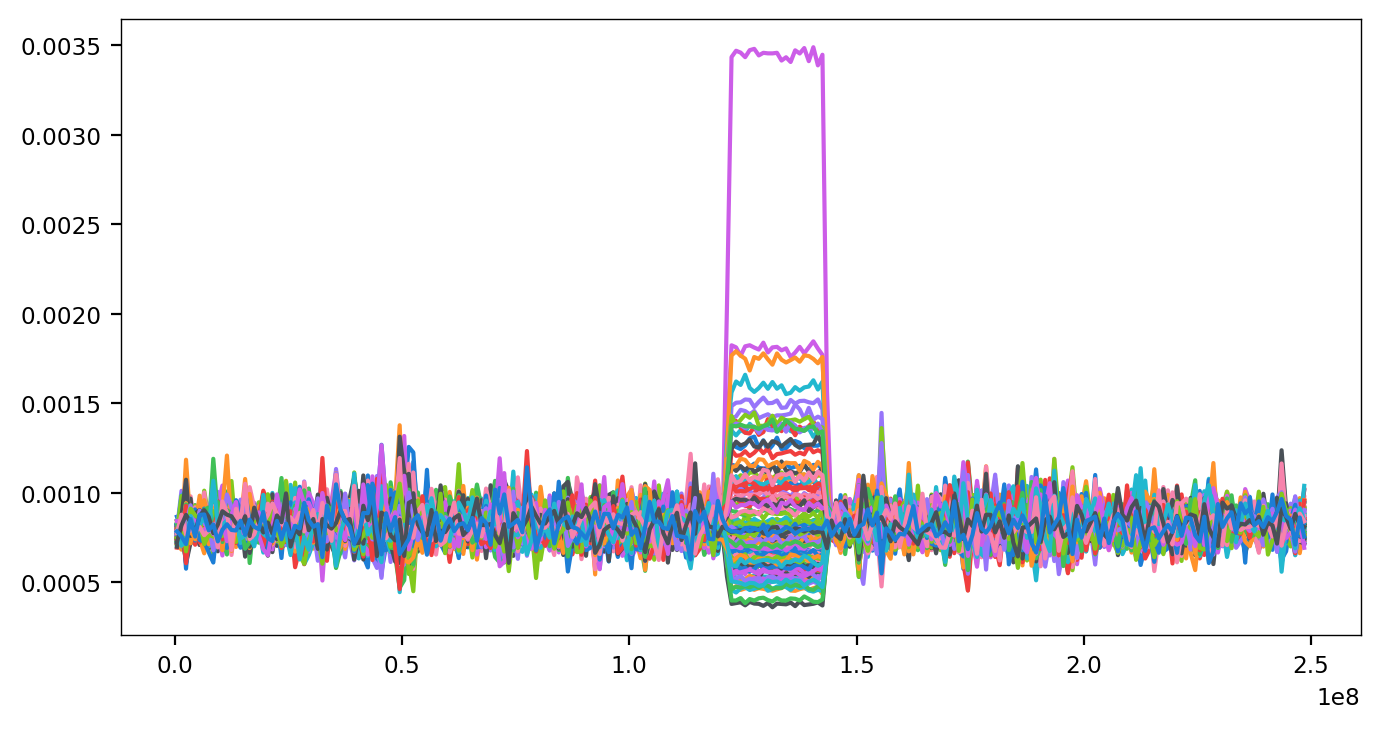

In [83]:
_ = plt.plot(chr1_mps, yri_pi_sims.T)

We clearly need to mask out the centromere — this is approximate since it matters little.

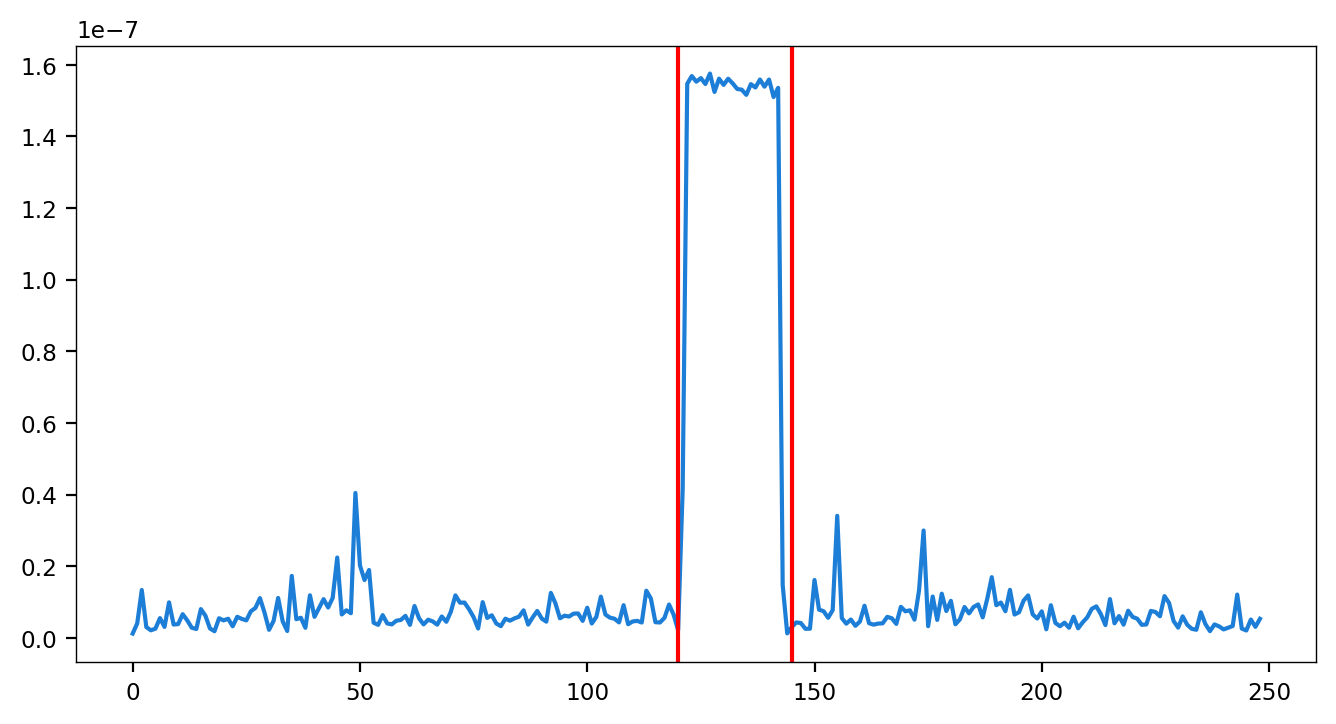

In [84]:
plt.plot(np.var(yri_pi_sims, axis=0))
plt.axvline(120, c='r')
plt.axvline(145, c='r')

In [85]:
yri_pi_sims[:, 120:145] = np.nan

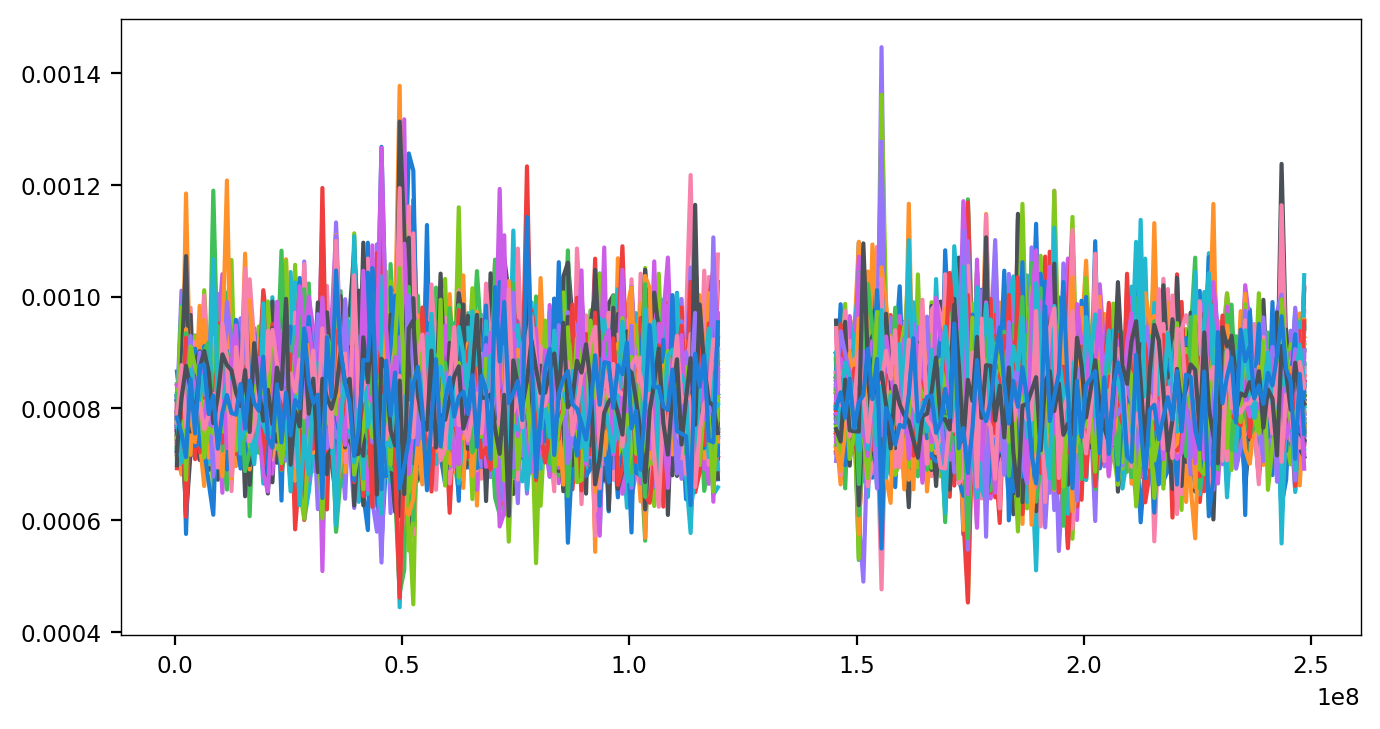

In [86]:
_ = plt.plot(chr1_mps, yri_pi_sims.T)

In [89]:
def sim_covariogram(pi, mbins, nlags=50, recmap=None, corr=True):
    lags = list(range(1, 50))
    covs = []
    dists = []
    for lag in lags:
        if not corr:
            covs.append(covar(pi[lag:], pi[:-lag]))
        else:
            covs.append(corr2(pi[lag:], pi[:-lag]))
        dist = np.nanmean(np.abs(mbins[lag:] - mbins[:-lag]))
        dists.append(dist)

    dists, covs = np.array(dists), np.array(covs)
    idx = np.argsort(dists)
    dists = dists[idx]
    covs = covs[idx]
    return np.array(lags), dists, covs


mbins = g.recmap.lookup('chr1', chr1_mps, cumulative=True)

dists = []
covarios = []
for i in np.arange(yri_pi_sims.shape[0]):
    lags, dist, covario = sim_covariogram(yri_pi_sims[i, :], mbins)
    dists.append(dist)
    covarios.append(covario)

dists = np.array(dists)
covarios = np.array(covarios)

In [90]:
#np.array([x[1] for x in bins_1Mbp.flat_midpoints()]), np.array(chr1_mps)

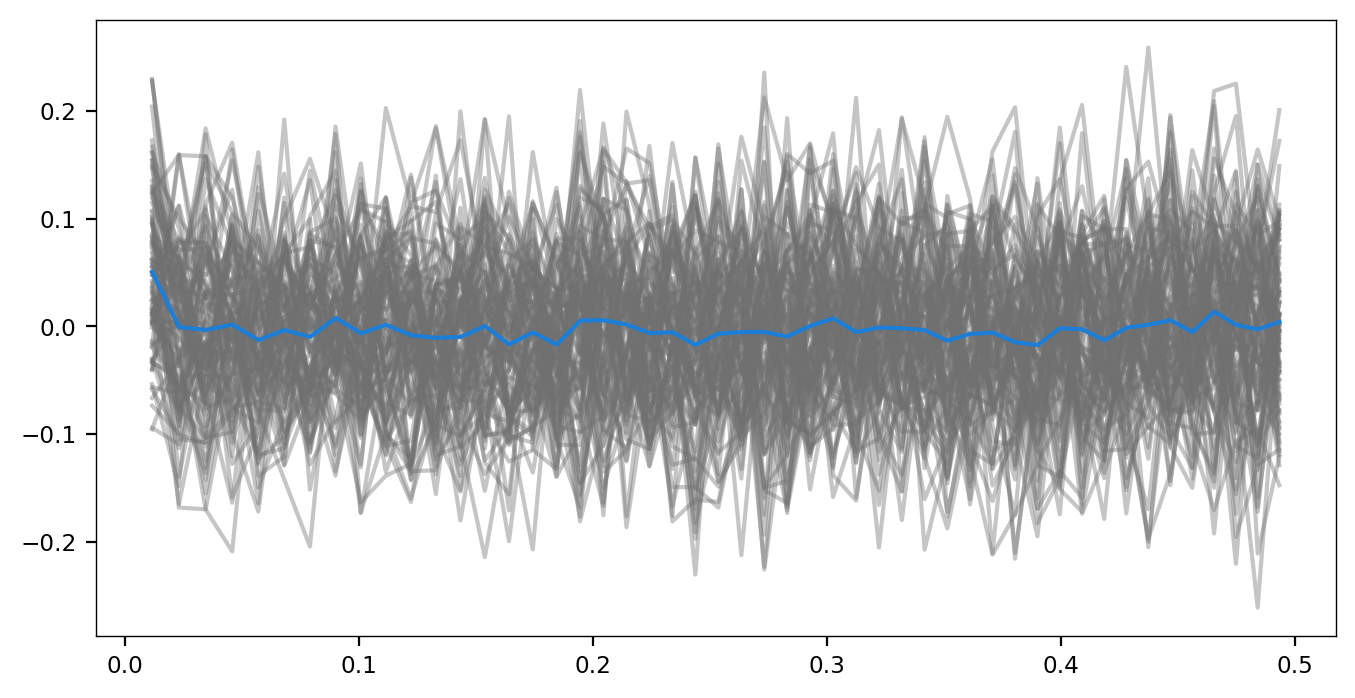

In [91]:
_ = plt.plot(dists.T, covarios.T, c='0.44', alpha=0.4)
plt.plot(dists.mean(axis=0), covarios.mean(axis=0))

### Linkage Disequilibrium Data

We use HapMap LD data to get a sense of the scale of LD decay for comparison in the figure.
 
Data is from:

```
$ wget ftp://ftp.ncbi.nlm.nih.gov/hapmap//ld_data/2009-04_rel27/ld_chr1_YRI.txt.gz
```

In [92]:
hapmap_cols = 'pos1,pos2,pop,rs1,rs2,D,R2,LOD,,fbin'.split(',')
d = pd.read_csv('../data/ld_chr1_YRI.txt.gz', sep=' ', names=hapmap_cols)

In [93]:
d.shape

(14083657, 10)

In [94]:
d.head()

pos1    pos2  pop        rs1         rs2    D     R2   LOD     fbin
0  556738  576058  YRI  rs2185539  rs28446478  1.0  0.000  0.04  5   NaN
1  556738  711153  YRI  rs2185539  rs12565286  1.0  0.000  0.00  5   NaN
2  556738  718814  YRI  rs2185539  rs11240767  1.0  0.001  0.09  5   NaN
3  556738  724325  YRI  rs2185539  rs12564807  1.0  0.000  0.00  5   NaN
4  556738  730720  YRI  rs2185539  rs12082473  1.0  0.001  0.10  5   NaN

In [96]:
map_pos1 = g.recmap.lookup('chr1', d['pos1'], cumulative=True)
map_pos2 = g.recmap.lookup('chr1', d['pos2'], cumulative=True)

In [97]:
#x, y = np.abs(d['pos1'] - d['pos2']), d['R2']
x, y = np.abs(map_pos1 - map_pos2), d['R2']

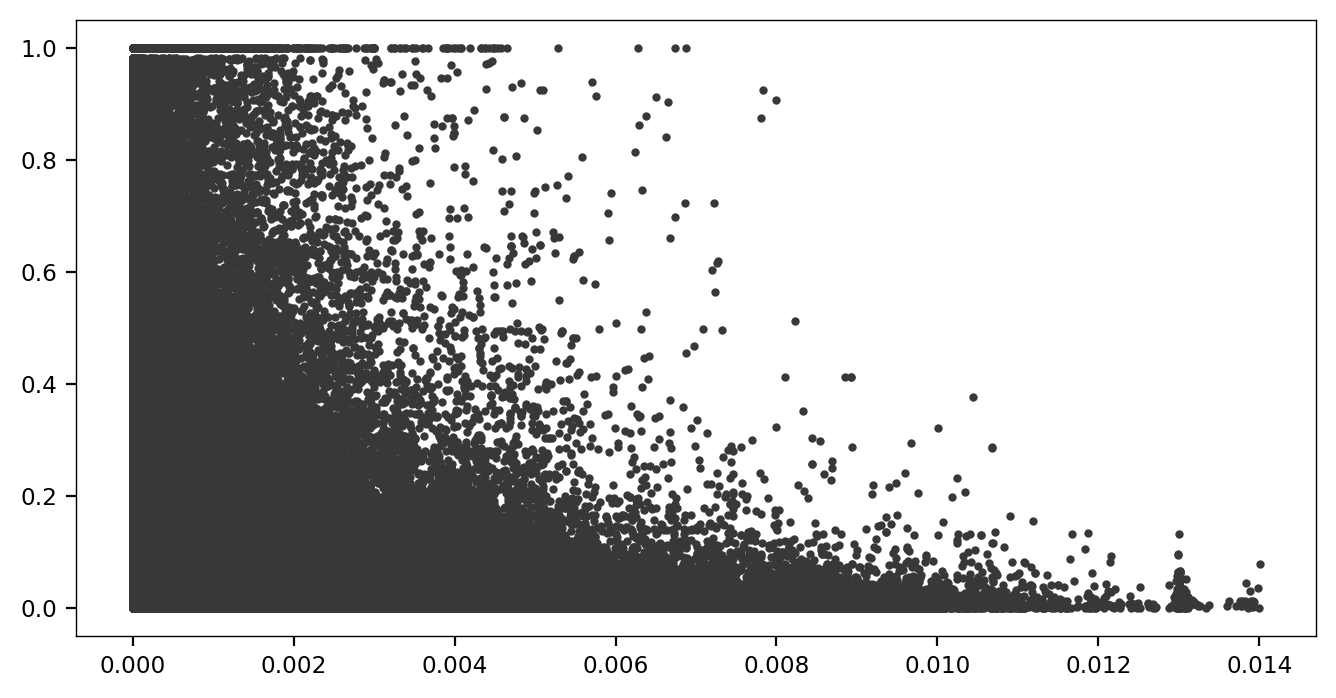

In [98]:
idx = np.random.randint(0, len(x), 1000000)
plt.scatter(x[idx], y[idx], c='0.22', s=4)

In [99]:
def count_bins(x, count):
    """
    Create bins trying to balance number of items in a bin to count.
    """
    bins = []
    nitems = 0
    for el in np.sort(x):
        if nitems > count:
            bins.append(el)
            nitems = 0
        nitems += 1
    bins.append(el)
    return bins
ld_xbins = np.linspace(0, 0.002, 200)
#ld_xbins = np.logspace(-6, -2, 50)
ld_xbins = count_bins(x, 100000)
r2_bins = stats.binned_statistic(x, y, bins=ld_xbins, statistic=np.nanmean)

(-3e-05, 0.002)

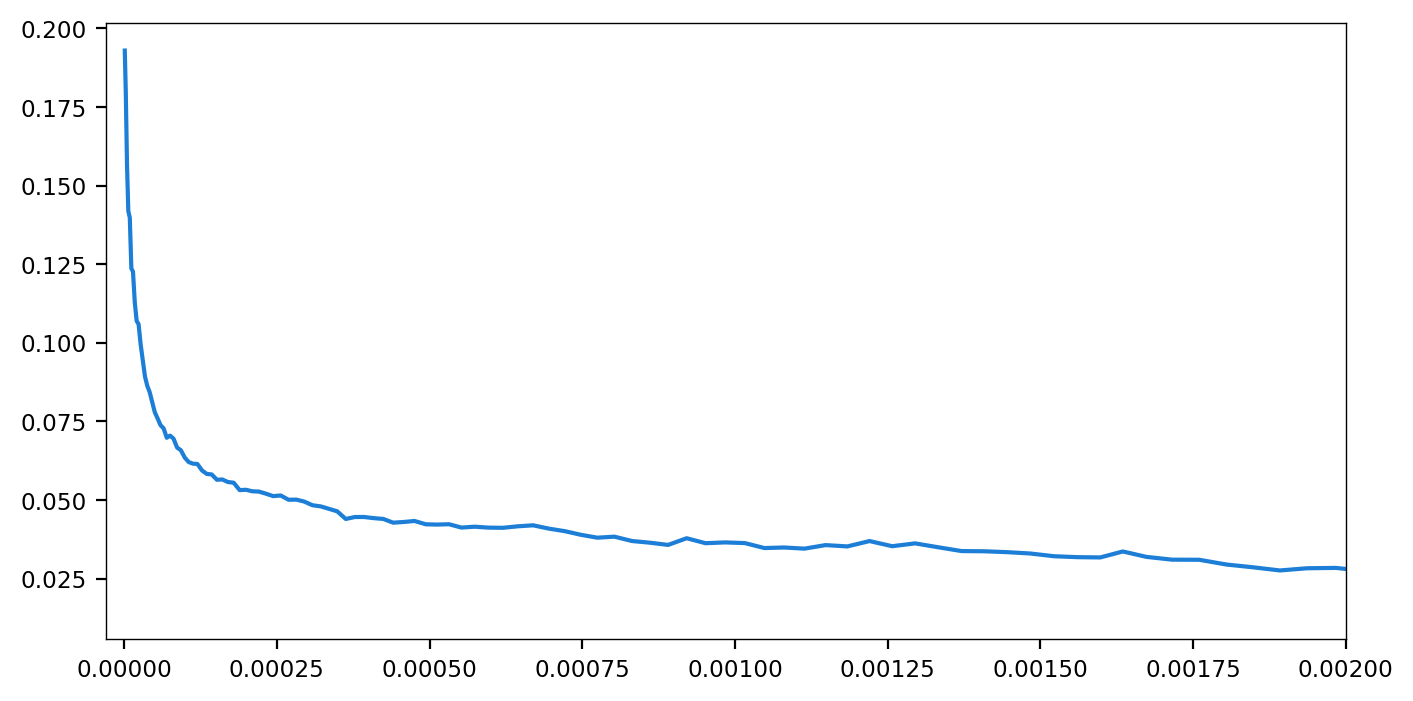

In [100]:
fig, ax = plt.subplots()
ldx = 0.5*(r2_bins.bin_edges[1:] + r2_bins.bin_edges[:-1])
ax.plot(ldx, r2_bins.statistic)
ax.set_xlim(-0.00003, 0.002)
#ax.set_ylim(0, 0.15)

ValueError: x and y must have same first dimension, but have shapes (100,) and (140,)

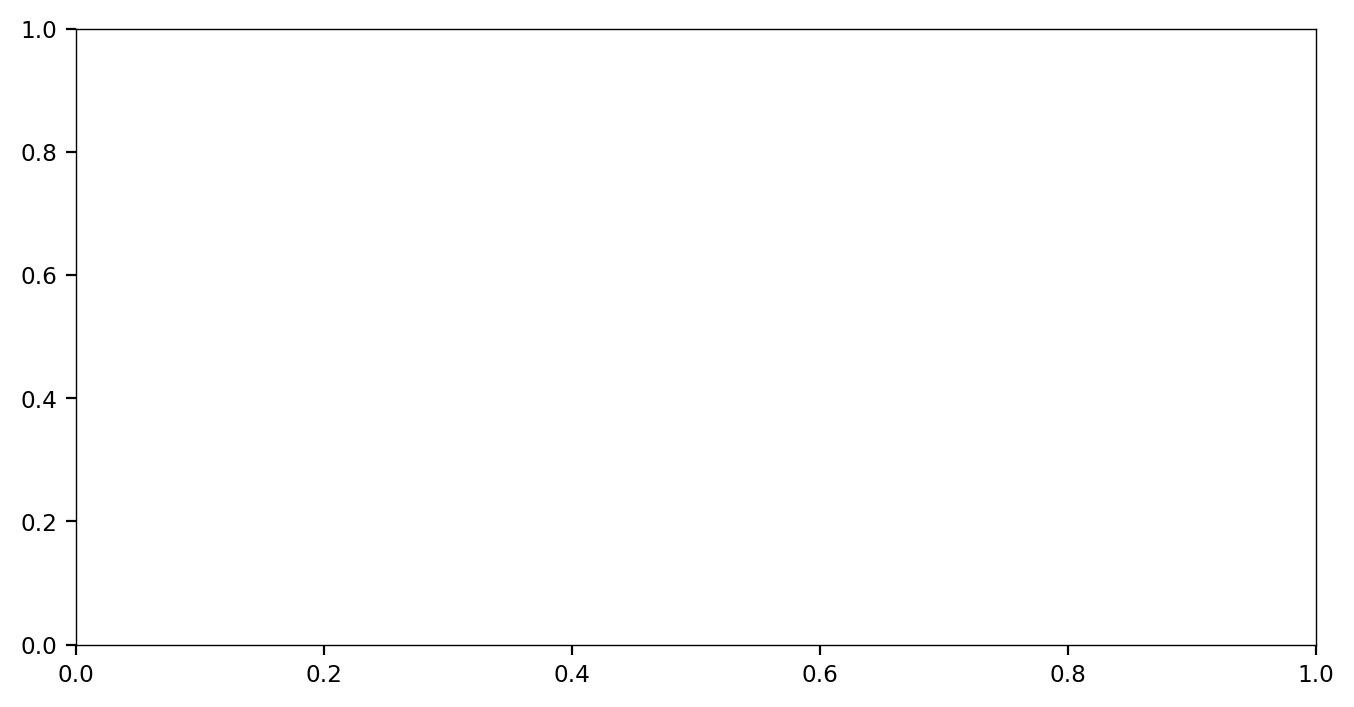

In [101]:
xd, yd = np.abs(d['pos1'] - d['pos2']), d['R2']
r2d_bins = stats.binned_statistic(xd, yd, bins=100)
plt.plot(r2d_bins.bin_edges[1:]*1e-8, r2_bins.statistic)

### Covariogram Figure for Paper

In [ ]:
fig, ax = plt.subplots()

ax.plot(stat(R_cor, axis=1), np.nanmean(M_cor, axis=1), c='cornflowerblue',
        label='observed (YRI)', zorder=2)
covario_cis = percentile_ci(np.stack(bs).T)
ax.fill_between(stat(R_cor, axis=1), *covario_cis, color='cornflowerblue',
                alpha=0.3, linewidth=0, zorder=2)
ax.axhline(0, linestyle='dashed', c='0.22', zorder=-10)

sim_covario_cis = percentile_ci(covarios.T)
ax.fill_between(dists.mean(axis=0), *sim_covario_cis, color='green', 
                linewidth=0, alpha=0.2)
ax.plot(dists.mean(axis=0), covarios.mean(axis=0), color='green', 
        alpha=0.4, label='neutral simulations')
sim_covario_cis[0].shape
ax.set_xlim(0, 0.5)

top_inset = 0.73
inset_ax = ax.inset_axes((0.6, top_inset, 0.28, 0.28))

inset_ax.plot(*lowess(r2_bins.statistic, ldx, frac=0.008).T, c='0.22')
inset_ax.set_ylim(0.00, 0.2)
inset_ax.set_xlim(-0.00005, 0.002)
#inset_ax.axhline(0, linestyle='dashed', c='0.22', zorder=10, linewidth=1)
inset_ax.spines['right'].set_visible(True)
inset_ax.spines['top'].set_visible(True)
inset_ax.set_ylabel("LD $R^2$")

# ax2 = ax.inset_axes((0.25, top_inset, 0.3, 0.3))
# ax2.plot(r2_bins.bin_edges[1:]*1e-8, r2_bins.statistic)
# ax2.spines['right'].set_visible(True)
# ax2.spines['top'].set_visible(True)
# ax2.set_ylabel("$R^2$")
# ax2.set_ylim(0., 0.3)

ax.set_ylabel('genomic autocorrelation of $\pi$')
ax.set_xlabel('lag (Morgans)')
ax.legend(loc='lower left')